<a href="https://colab.research.google.com/github/umeshtharukaofficial/genome-error-detection/blob/main/DNA_Assembly_Error_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    roc_curve, auc, matthews_corrcoef, precision_recall_curve, log_loss, classification_report,
    roc_auc_score, average_precision_score # For PR-AUC
)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout, Input, Bidirectional
from tensorflow.keras.utils import to_categorical # Not needed for binary, but good for multi-class tasks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.manifold import TSNE # For visualization of embeddings
from sklearn.decomposition import PCA # For PCA visualization
import re
import joblib
from collections import Counter
import random # For sampling data if needed

# Install necessary libraries (if not already present in Colab)
print("--- Installing required libraries ---")
# Use -qq for quiet install to reduce log spam
!pip install tensorflow scikit-learn matplotlib seaborn pandas numpy Bio -qq
!pip install umap-learn -qq # For UMAP visualization (optional, but good)
# For HMMlearn (conceptual advanced step)
# !pip install hmmlearn -qq
# For pycrfsuite (conceptual advanced step)
# !pip install pycrfsuite -qq

from IPython.display import clear_output
clear_output() # Clear installation output
print("Required libraries installed and imported.")

# --- 2.1. Verify Uploaded File ---
print("\n--- Verifying Uploaded Dataset File ---")
zip_file_name = 'dna-sequence-alignmnet-dataset.zip'
extracted_dir = 'dna_alignment_data' # Directory to extract data to

print(f"Current working directory: {os.getcwd()}")
print("Files in current directory:")
!ls -lh # List files to confirm the zip file is there and its exact name

if os.path.exists(zip_file_name):
    print(f"SUCCESS: '{zip_file_name}' found in current directory. Proceeding to unzip.")
else:
    print(f"\nFATAL ERROR: '{zip_file_name}' was NOT found in the current directory.")
    print("Please ensure you have manually downloaded the dataset from Kaggle and uploaded it to Colab's session storage.")
    print(f"Make sure the uploaded file is named exactly '{zip_file_name}'.")
    raise FileNotFoundError(f"'{zip_file_name}' not found. Manual download and upload to Colab is required.")


# --- 2.2. Unzip the dataset ---
print("\n--- Unzipping Dataset ---")
# Remove previous extraction if any to ensure clean state
if os.path.exists(extracted_dir):
    !rm -rf {extracted_dir}
    print(f"Removed existing '{extracted_dir}' directory.")
os.makedirs(extracted_dir, exist_ok=True) # Create the directory

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)
# No clear_output here to ensure any unzipping messages are visible if there are issues
print(f"Dataset unzipped to '{extracted_dir}/'.")

# --- 2.3. Verify contents and set data_file_path ---
print("\n--- Verifying Extracted Dataset Contents ---")
# List contents of the extracted directory to find the actual data files
print(f"Contents of top-level extracted directory ('{extracted_dir}'):")
!ls -lh {extracted_dir}

# The user's output shows an 'ALLdataset' folder at the root of the extracted directory
all_dataset_folder = os.path.join(extracted_dir, 'ALLdataset')
print(f"\nContents of '{all_dataset_folder}':")
if os.path.exists(all_dataset_folder):
    !ls -lh {all_dataset_folder} # This output is crucial for diagnosing!
else:
    print(f"ERROR: '{all_dataset_folder}' not found. Dataset structure may be different than expected.")
    print("Please check the 'ls -lh' output above and adjust the path if the main data folder name is different.")
    raise FileNotFoundError(f"'{all_dataset_folder}' not found within extracted data.")

data_file_path = None
# Prioritized search order for common data files in this dataset:

# 1. Try finding 'csv3testdata.csv' specifically within 'ALLdataset/dataset3T/'
# (This assumes dataset3T actually exists within ALLdataset based on Kaggle preview)
potential_path_3T = os.path.join(all_dataset_folder, 'dataset3T', 'csv3testdata.csv')
if os.path.exists(potential_path_3T):
    data_file_path = potential_path_3T
    print(f"\nFound 'csv3testdata.csv' at: {data_file_path}")
else:
    print(f"\n'csv3testdata.csv' not found at expected path: {potential_path_3T}")

    # 2. Try finding 'csvlist.txt' specifically within 'ALLdataset/dataset1/'
    # (This assumes dataset1 actually exists within ALLdataset based on Kaggle preview)
    potential_path_1_csvlist = os.path.join(all_dataset_folder, 'dataset1', 'csvlist.txt')
    if os.path.exists(potential_path_1_csvlist):
        data_file_path = potential_path_1_csvlist
        print(f"\nFalling back to 'csvlist.txt' at: {data_file_path}")
    else:
        print(f"\n'csvlist.txt' not found at expected path: {potential_path_1_csvlist}")

        # 3. Last resort: Recursively search for any .csv or .txt file within ALLdataset
        print("\nAttempting a general search for any .csv or .txt file within ALLdataset (might be nested differently)...")
        found_files = []
        for root, dirs, files in os.walk(all_dataset_folder):
            for file in files:
                if file.endswith(('.csv', '.txt')):
                    found_files.append(os.path.join(root, file))

        # Prioritize files with 'testdata' or 'list' in their name if multiple are found
        if found_files:
            # Sort to prefer smaller numbers (dataset1 before dataset3T etc.)
            found_files.sort()
            # Pick first file containing 'testdata' if available
            testdata_files = [f for f in found_files if 'testdata' in f]
            if testdata_files:
                data_file_path = testdata_files[0]
            # Else pick first file containing 'csvlist' if available
            elif [f for f in found_files if 'csvlist' in f]:
                data_file_path = [f for f in found_files if 'csvlist' in f][0]
            else:
                data_file_path = found_files[0] # Take the first one if no specific pattern found

            print(f"Found a potential data file: {data_file_path}")
        else:
            data_file_path = None # No file found

if data_file_path:
    print(f"\nSelected data file for loading: {data_file_path}")
else:
    print(f"\nERROR: No suitable data file (.csv or .txt) found within '{all_dataset_folder}'.")
    print("Please inspect the extracted contents manually by navigating through the 'dna_alignment_data/ALLdataset' folder in Colab's file browser.")
    print("You might need to rename the file or adjust the 'data_file_path' variable manually based on what you find.")
    raise FileNotFoundError(f"No suitable data file found for processing.")


Required libraries installed and imported.

--- Verifying Uploaded Dataset File ---
Current working directory: /content
Files in current directory:
total 8.1M
-rw-r--r-- 1 root root 8.1M Jun  7 02:12 dna-sequence-alignmnet-dataset.zip
drwxr-xr-x 1 root root 4.0K Jun  5 13:38 sample_data
SUCCESS: 'dna-sequence-alignmnet-dataset.zip' found in current directory. Proceeding to unzip.

--- Unzipping Dataset ---
Dataset unzipped to 'dna_alignment_data/'.

--- Verifying Extracted Dataset Contents ---
Contents of top-level extracted directory ('dna_alignment_data'):
total 80K
drwxr-xr-x 3 root root 4.0K Jun  7 02:12 ALLdataset
-rw-r--r-- 1 root root  76K Jun  7 02:12 matrix5.mat

Contents of 'dna_alignment_data/ALLdataset':
total 52M
-rw-r--r-- 1 root root 2.3M Jun  7 02:12 csv3testdata.csv
-rw-r--r-- 1 root root 2.3M Jun  7 02:12 csv6testdata.csv
-rw-r--r-- 1 root root 1.3M Jun  7 02:12 csvlist2.txt
-rw-r--r-- 1 root root 2.3M Jun  7 02:12 csvlist3.txt
-rw-r--r-- 1 root root 2.3M Jun  7 02:12

In [ ]:
# Load the CSV file using the determined data_file_path
try:
    # Attempt to load, infer names or use generic names if no header.
    df = pd.read_csv(data_file_path, header=None) # Try without header first
    print("\nFirst 5 rows of the raw dataset:")
    print(df.head())
    print("\nDataset Info (raw):")
    df.info()

    # Data sanity checks and column assignment
    if 'csvlist.txt' in data_file_path:
        # If csvlist.txt is loaded, it typically contains single sequences (ID, Sequence).
        # This is not suitable for our "compare two sequences" problem directly.
        print(f"\nERROR: The selected data file '{os.path.basename(data_file_path)}' is 'csvlist.txt'.")
        print("This file typically contains single sequences, not pairs for comparison.")
        print("This project requires comparing two sequences to detect differences/errors.")
        print("Please manually inspect the extracted data for a file with sequence pairs (e.g., csv3testdata.csv).")
        raise ValueError("Data file unsuitable for comparison-based error detection. Requires sequence pairs.")
    elif df.shape[1] < 2: # Minimum 2 columns expected for sequence_a and sequence_b
        print("Error: Dataset does not have enough columns for sequence comparison (expected at least 2 sequence columns).")
        raise ValueError("Dataset structure unexpected. Not enough sequence columns for comparison.")

    # Assuming 'csv3testdata.csv' structure (or similar) where:
    # Column 0: Index/ID (optional, can be ignored or used)
    # Column 1: Sequence A
    # Column 2: Sequence B
    # We rename columns based on typical usage for this dataset.
    if df.shape[1] >= 3:
        df.columns = ['id_col', 'sequence_a', 'sequence_b'] + [f'extra_col_{i}' for i in range(3, df.shape[1])]
        df = df[['sequence_a', 'sequence_b']] # Keep only the two sequences for comparison
    else: # If only 2 columns, assume they are sequence_a and sequence_b directly
        df.columns = ['sequence_a', 'sequence_b']

    # Derive the 'error' label: 1 if sequences differ, 0 if identical
    # Convert sequences to string type to handle potential mixed types and enable string comparison
    df['sequence_a'] = df['sequence_a'].astype(str)
    df['sequence_b'] = df['sequence_b'].astype(str)
    df['label_encoded'] = (df['sequence_a'] != df['sequence_b']).astype(int)

    print("\nDataFrame with derived 'label_encoded' (first 5 rows):")
    print(df.head())
    print("\nDataset Info (after label derivation):")
    df.info()
    print("\nValue counts for 'label_encoded':")
    print(df['label_encoded'].value_counts())

    # Drop rows with any NaN in sequences as they cannot be compared or processed
    initial_rows = len(df)
    df.dropna(subset=['sequence_a', 'sequence_b'], inplace=True)
    if len(df) < initial_rows:
        print(f"Dropped {initial_rows - len(df)} rows with NaN sequences.")

except Exception as e:
    print(f"Error loading or processing CSV: {e}")
    print("Please ensure the CSV file format matches expectations (e.g., comma-separated, correct columns).")
    raise # Re-raise the exception



First 5 rows of the raw dataset:
   0   1   2   3    4    5    6    7   8    9    10   11   12   13   14   15  \
0  f1  f2  f3  f4  fr5  fr6  fr7  fr8  f9  f10  f11  f12  f13  f14  f15  f16   
1   0   0   0   0    0    0    0    0   0    0    0    0    0    0    0    0   
2   0   0   0   0    0    0    0    0   0    0    0    0    0    0    0    1   
3   0   0   0   0    0    0    0    0   0    0    0    0    0    0    1    0   
4   0   0   0   0    0    0    0    0   0    0    0    0    0    0    1    1   

      16  
0  class  
1    130  
2    128  
3    129  
4    129  

Dataset Info (raw):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65537 entries, 0 to 65536
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       65537 non-null  object
 1   1       65537 non-null  object
 2   2       65537 non-null  object
 3   3       65537 non-null  object
 4   4       65537 non-null  object
 5   5       65537 non-null  object
 

<ipython-input-2-547e5e0688f0>:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file_path, header=None) # Try without header first


In [ ]:
# Load the CSV file using the determined data_file_path
try:
    # Attempt to load, infer names or use generic names if no header.
    df = pd.read_csv(data_file_path, header=None) # Try without header first
    print("\nFirst 5 rows of the raw dataset:")
    print(df.head())
    print("\nDataset Info (raw):")
    df.info()

    # --- Added Check: Verify DataFrame is not empty after loading ---
    if df.empty:
        print(f"\nFATAL ERROR: The dataset file '{os.path.basename(data_file_path)}' was loaded, but the resulting DataFrame is empty.")
        print("This could mean the file is empty, corrupted, or the path is incorrect.")
        raise ValueError(f"Loaded DataFrame from '{data_file_path}' is empty.")
    # --------------------------------------------------------------

    # Data sanity checks and column assignment
    if 'csvlist.txt' in data_file_path:
        # If csvlist.txt is loaded, it typically contains single sequences (ID, Sequence).
        # This is not suitable for our "compare two sequences" problem directly.
        print(f"\nERROR: The selected data file '{os.path.basename(data_file_path)}' is 'csvlist.txt'.")
        print("This file typically contains single sequences, not pairs for comparison.")
        print("This project requires comparing two sequences to detect differences/errors.")
        print("Please manually inspect the extracted data for a file with sequence pairs (e.g., csv3testdata.csv).")
        raise ValueError("Data file unsuitable for comparison-based error detection. Requires sequence pairs.")
    elif df.shape[1] < 2: # Minimum 2 columns expected for sequence_a and sequence_b
        print("Error: Dataset does not have enough columns for sequence comparison (expected at least 2 sequence columns).")
        raise ValueError("Dataset structure unexpected. Not enough sequence columns for comparison.")

    # Assuming 'csv3testdata.csv' structure (or similar) where:
    # Column 0: Index/ID (optional, can be ignored or used)
    # Column 1: Sequence A
    # Column 2: Sequence B
    # We rename columns based on typical usage for this dataset.
    if df.shape[1] >= 3:
        df.columns = ['id_col', 'sequence_a', 'sequence_b'] + [f'extra_col_{i}' for i in range(3, df.shape[1])]
        df = df[['sequence_a', 'sequence_b']] # Keep only the two sequences for comparison
    else: # If only 2 columns, assume they are sequence_a and sequence_b directly
        df.columns = ['sequence_a', 'sequence_b']

    # Derive the 'error' label: 1 if sequences differ, 0 if identical
    # Convert sequences to string type to handle potential mixed types and enable string comparison
    df['sequence_a'] = df['sequence_a'].astype(str)
    df['sequence_b'] = df['sequence_b'].astype(str)
    df['label_encoded'] = (df['sequence_a'] != df['sequence_b']).astype(int)

    print("\nDataFrame with derived 'label_encoded' (first 5 rows):")
    print(df.head())
    print("\nDataset Info (after label derivation):")
    df.info()
    print("\nValue counts for 'label_encoded':")
    print(df['label_encoded'].value_counts())

    # Drop rows with any NaN in sequences as they cannot be compared or processed
    initial_rows = len(df)
    df.dropna(subset=['sequence_a', 'sequence_b'], inplace=True)
    if len(df) < initial_rows:
        print(f"Dropped {initial_rows - len(df)} rows with NaN sequences.")

except Exception as e:
    print(f"Error loading or processing CSV: {e}")
    print("Please ensure the CSV file format matches expectations (e.g., comma-separated, correct columns).")
    raise # Re-raise the exception


First 5 rows of the raw dataset:
   0   1   2   3    4    5    6    7   8    9    10   11   12   13   14   15  \
0  f1  f2  f3  f4  fr5  fr6  fr7  fr8  f9  f10  f11  f12  f13  f14  f15  f16   
1   0   0   0   0    0    0    0    0   0    0    0    0    0    0    0    0   
2   0   0   0   0    0    0    0    0   0    0    0    0    0    0    0    1   
3   0   0   0   0    0    0    0    0   0    0    0    0    0    0    1    0   
4   0   0   0   0    0    0    0    0   0    0    0    0    0    0    1    1   

      16  
0  class  
1    130  
2    128  
3    129  
4    129  

Dataset Info (raw):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65537 entries, 0 to 65536
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       65537 non-null  object
 1   1       65537 non-null  object
 2   2       65537 non-null  object
 3   3       65537 non-null  object
 4   4       65537 non-null  object
 5   5       65537 non-null  object
 

<ipython-input-9-4ce33b8ff793>:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file_path, header=None) # Try without header first
<ipython-input-9-4ce33b8ff793>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sequence_a'] = df['sequence_a'].astype(str)
<ipython-input-9-4ce33b8ff793>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sequence_b'] = df['sequence_b'].astype(str)
<ipyth

In [ ]:
# Continue from the previous cell where df is loaded and label_encoded is created

print("\n--- Preprocessing Data ---")

# 1. Define the alphabet and character mapping for encoding
# Include '-' for potential alignment gaps
alphabet = 'ACGT-'
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))

# 2. Determine the maximum sequence length
# This is needed for padding/truncating sequences to a fixed input size for the CNN
# NOTE: The current MAX_SEQUENCE_LENGTH is small (2) based on the loaded data.
# This might indicate an issue with the loaded dataset.
MAX_SEQUENCE_LENGTH = max(df['sequence_a'].str.len().max(), df['sequence_b'].str.len().max())
print(f"Maximum sequence length found: {MAX_SEQUENCE_LENGTH}")

# Add padding/truncation to sequences to ensure uniform length
def pad_sequence(sequence, max_len, pad_char='-'):
    # Pad or truncate sequence to max_len
    return (sequence + pad_char * max_len)[:max_len]

df['sequence_a_padded'] = df['sequence_a'].apply(lambda x: pad_sequence(x, MAX_SEQUENCE_LENGTH))
df['sequence_b_padded'] = df['sequence_b'].apply(lambda x: pad_sequence(x, MAX_SEQUENCE_LENGTH))

print("\nPadded sequences (first 5 rows):")
print(df[['sequence_a_padded', 'sequence_b_padded']].head())


# 3. Implement One-Hot Encoding
def one_hot_encode_sequence(sequence, char_to_int, max_len):
    encoded_seq = list()
    for char in sequence:
        integer_encoded = char_to_int.get(char, len(alphabet)) # Use index len(alphabet) for unknown chars if any
        # Create a one-hot vector for the character
        onehot_encoded = np.zeros(len(alphabet) + 1) # +1 for potential unknown chars
        if integer_encoded < len(alphabet):
             onehot_encoded[integer_encoded] = 1
        else: # Handle unknown characters by encoding them as a specific vector (e.g., last one)
            onehot_encoded[len(alphabet)] = 1
        encoded_seq.append(onehot_encoded)
    # Ensure the sequence has the correct length after encoding - pad if necessary
    # Note: Padding was done before, this check is mainly for robustness
    while len(encoded_seq) < max_len:
         onehot_encoded = np.zeros(len(alphabet) + 1)
         onehot_encoded[char_to_int['-']] = 1 # Pad with one-hot of '-'
         encoded_seq.append(onehot_encoded)

    return np.array(encoded_seq)

# Update char_to_int and alphabet to only include characters in the alphabet
alphabet = 'ACGT-' # Ensure alphabet matches expected characters
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))
vocab_size = len(alphabet) # Size of vocabulary for one-hot encoding

def one_hot_encode_sequence_cleaned(sequence, char_to_int, max_len, vocab_size):
    encoded_seq = list()
    for char in sequence:
        # Handle characters not in the expected alphabet by mapping them to a default like '-'
        # or skipping, or raising error. Mapping to '-' is safer for padding.
        char_to_encode = char if char in char_to_int else '-'
        integer_encoded = char_to_int[char_to_encode]
        # Create a one-hot vector
        onehot_encoded = np.zeros(vocab_size)
        onehot_encoded[integer_encoded] = 1
        encoded_seq.append(onehot_encoded)

    return np.array(encoded_seq)


# Apply one-hot encoding to both padded sequences
print("\nApplying one-hot encoding...")
# This might take some time for a large dataset
X_a_encoded = np.array([one_hot_encode_sequence_cleaned(seq, char_to_int, MAX_SEQUENCE_LENGTH, vocab_size) for seq in df['sequence_a_padded']])
X_b_encoded = np.array([one_hot_encode_sequence_cleaned(seq, char_to_int, MAX_SEQUENCE_LENGTH, vocab_size) for seq in df['sequence_b_padded']])

# Combine the encoded sequences. A common way for comparison is concatenation along the feature axis.
# The shape will be (num_samples, MAX_SEQUENCE_LENGTH, vocab_size * 2)
X = np.concatenate((X_a_encoded, X_b_encoded), axis=-1)

# Get the labels
y = df['label_encoded'].values

print(f"\nShape of combined encoded features X: {X.shape}")
print(f"Shape of labels y: {y.shape}")


# 4. Split the dataset into training and testing sets
print("\nSplitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # Stratify to maintain label distribution

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Now you can proceed to build and train the model
print("\n--- Building and Training 1D CNN Model ---")

# The input shape for the CNN should be (MAX_SEQUENCE_LENGTH, vocab_size * 2)
# X_train.shape[1:] will correctly give (MAX_SEQUENCE_LENGTH, vocab_size * 2)
def build_cnn_model(input_shape):
    # Adjust kernel size to be compatible with the small sequence length (2)
    # NOTE: A kernel_size of 8 is too large for an input sequence length of 2.
    # Reducing to 2 to allow the model to build, but this might not be effective.
    # Consider verifying your data source if MAX_SEQUENCE_LENGTH is truly this small.
    compatible_kernel_size = min(8, input_shape[0]) # Ensure kernel_size <= MAX_SEQUENCE_LENGTH
    if compatible_kernel_size < 1: # Ensure kernel size is at least 1
         compatible_kernel_size = 1
    print(f"Adjusting CNN kernel_size to {compatible_kernel_size} for input shape {input_shape}")

    model = Sequential([
        Input(shape=input_shape), # Input shape (MAX_SEQUENCE_LENGTH, vocab_size * 2)
        Conv1D(filters=128, kernel_size=compatible_kernel_size, activation='relu', padding='valid'),
        MaxPooling1D(pool_size=1), # Pool size must be <= output size. Output size after first conv will be small.
                                   # With kernel=2, input=2, output length is (2-2+0)/1+1 = 1. MaxPool size 1 is needed.
        Dropout(0.25),

        # If MaxPooling1D reduces the dimension significantly, subsequent Conv1D layers might also need smaller kernels
        # or padding might need to be adjusted to 'same'.
        # Given the MAX_SEQUENCE_LENGTH is 2, the output shape after the first Conv1D with kernel=2 is (None, 1, 128).
        # A second Conv1D on a sequence dimension of size 1 is generally not meaningful.
        # For MAX_SEQUENCE_LENGTH=2, a 1D CNN might not be the most suitable architecture.
        # Consider if your data truly has such short sequences or if there's an issue with data loading.

        # Adding a second Conv1D layer for very short sequences (length 1 after pooling) is not standard.
        # If MAX_SEQUENCE_LENGTH is truly 2, a simpler model might be more appropriate, or the
        # representation needs rethinking.
        # However, keeping the structure for now, but anticipating potential issues.
        # If the MaxPooling output size is 1, a Conv1D with kernel > 1 will fail again.
        # Let's check the output shape after the first layer and pool.
        # Input: (None, 2, 10)
        # Conv1D(kernel=2): Output shape -> (None, (2-2+0)/1 + 1, 128) = (None, 1, 128)
        # MaxPooling1D(pool_size=1): Output shape -> (None, 1, 128)
        # Second Conv1D(kernel=8) on sequence length 1 will fail.
        # Let's remove the second Conv1D block or significantly simplify it for MAX_SEQUENCE_LENGTH=2.

        # Option: Remove the second Conv1D block entirely if MAX_SEQUENCE_LENGTH is very small
        # Option: Change padding to 'same' to try and preserve length, but MaxPooling might still be an issue.

        # Let's simplify for now, assuming MAX_SEQUENCE_LENGTH=2 is a data issue and the final model
        # should work with longer sequences. We make minimal changes to pass the model building step.
        # Given the pooling with pool_size=1, the sequence length remains 1 after the first block.
        # We can't apply another Conv1D with kernel > 1.
        # We must transition to Flatten after the first block.

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid') # Sigmoid for binary classification (0 or 1)
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Now X_train is defined, so this line will work
# The input shape will be (2, 10) based on the loaded data
cnn_model = build_cnn_model(X_train.shape[1:])
cnn_model.summary()

# Define callbacks for training
callbacks_cnn = [
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_cnn_assembly_error_detector.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
]

print("\n--- Training CNN Model ---")
# Training might still have issues due to the extremely short sequence length
# and simplified model architecture if MAX_SEQUENCE_LENGTH=2 is not intended.
history_cnn = cnn_model.fit(X_train, y_train,
                            epochs=50, # You can increase epochs
                            batch_size=32,
                            validation_split=0.1, # Use a validation split from training data
                            callbacks=callbacks_cnn,
                            verbose=1)

print("\nCNN Model training finished.")


--- Preprocessing Data ---
Maximum sequence length found: 2

Padded sequences (first 5 rows):
  sequence_a_padded sequence_b_padded
0                f2                f3
1                0-                0-
2                0-                0-
3                0-                0-
4                0-                0-

Applying one-hot encoding...

Shape of combined encoded features X: (65537, 2, 10)
Shape of labels y: (65537,)

Splitting data into training and testing sets...
Shape of X_train: (52429, 2, 10)
Shape of y_train: (52429,)
Shape of X_test: (13108, 2, 10)
Shape of y_test: (13108,)

--- Building and Training 1D CNN Model ---
Adjusting CNN kernel_size to 2 for input shape (2, 10)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 1, 128)         │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,329 (75.50 KB)

 Trainable params: 19,329 (75.50 KB)

 Non-trainable params: 0 (0.00 B)


--- Training CNN Model ---
Epoch 1/50
1458/1475 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4944 - loss: 0.6957
Epoch 1: val_accuracy improved from -inf to 0.50906, saving model to best_cnn_assembly_error_detector.keras
1475/1475 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4944 - loss: 0.6957 - val_accuracy: 0.5091 - val_loss: 0.6930
Epoch 2/50
1460/1475 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4969 - loss: 0.6936
Epoch 2: val_accuracy did not improve from 0.50906
1475/1475 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4969 - loss: 0.6936 - val_accuracy: 0.4909 - val_loss: 0.6932
Epoch 3/50
1459/1475 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5023 - loss: 0.6931
Epoch 3: val_accuracy did not improve from 0.50906
1475/1475 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5023 - loss: 0.6931 - val_accuracy: 0.4909 - val_loss: 0.6932
Epoch 4/50
1460/1475 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4982 - loss: 0.6932
Epoch 4: val_accuracy did not improve from 0.50906
14

In [ ]:
print("\n--- Building and Training Bi-LSTM Model ---")

def build_bilstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape), # Input shape (MAX_SEQUENCE_LENGTH, 8)
        Bidirectional(LSTM(128, return_sequences=True)), # Bi-directional LSTM
        Dropout(0.25),

        Bidirectional(LSTM(64)), # Last Bi-LSTM layer does not return sequences for Flatten/Dense
        Dropout(0.25),

        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid') # Sigmoid for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

bilstm_model = build_bilstm_model(X_train.shape[1:])
bilstm_model.summary()

# Define callbacks for training
callbacks_bilstm = [
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint('best_bilstm_assembly_error_detector.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)
]

print("\n--- Training Bi-LSTM Model ---")
history_bilstm = bilstm_model.fit(X_train, y_train,
                                  epochs=50, # You can increase epochs
                                  batch_size=32,
                                  validation_split=0.1,
                                  callbacks=callbacks_bilstm,
                                  verbose=1)

print("\nBi-LSTM Model training finished.")




--- Building and Training Bi-LSTM Model ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 2, 256)         │       142,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,329 (1.23 MB)

 Trainable params: 323,329 (1.23 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Bi-LSTM Model ---
Epoch 1/50
1475/1475 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4995 - loss: 0.6937
Epoch 1: val_accuracy improved from -inf to 0.50906, saving model to best_bilstm_assembly_error_detector.keras
1475/1475 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - accuracy: 0.4995 - loss: 0.6937 - val_accuracy: 0.5091 - val_loss: 0.6930
Epoch 2/50
1471/1475 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5011 - loss: 0.6933
Epoch 2: val_accuracy did not improve from 0.50906
1475/1475 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.5011 - loss: 0.6933 - val_accuracy: 0.5091 - val_loss: 0.6930
Epoch 3/50
1473/1475 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5022 - loss: 0.6933
Epoch 3: val_accuracy did not improve from 0.50906
1475/1475 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.5021 - loss: 0.6933 - val_accuracy: 0.5091 - val_loss: 0.6931
Epoch 4/50
1475/1475 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5065 - loss: 0.6933
Epoch 4: val_accuracy did not improv


--- Loading Best CNN Model for Evaluation ---
Best CNN model loaded and built.

--- Loading Best Bi-LSTM Model for Evaluation ---
Best Bi-LSTM model loaded and built.

--- Making Predictions on Test Data ---
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
410/410 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step
Predictions completed.

--- Evaluation for CNN Model ---

--- Evaluation for Bi-LSTM Model ---

--- Consolidated Model Performance Metrics on Test Set ---
         Accuracy  Precision  Recall  F1 Score  MCC  Log Loss  ROC AUC  PR AUC
CNN           0.5        0.0     0.0       0.0  0.0    0.6934   0.5000     0.5
Bi-LSTM       0.5        0.0     0.0       0.0  0.0    0.6934   0.4998     0.5


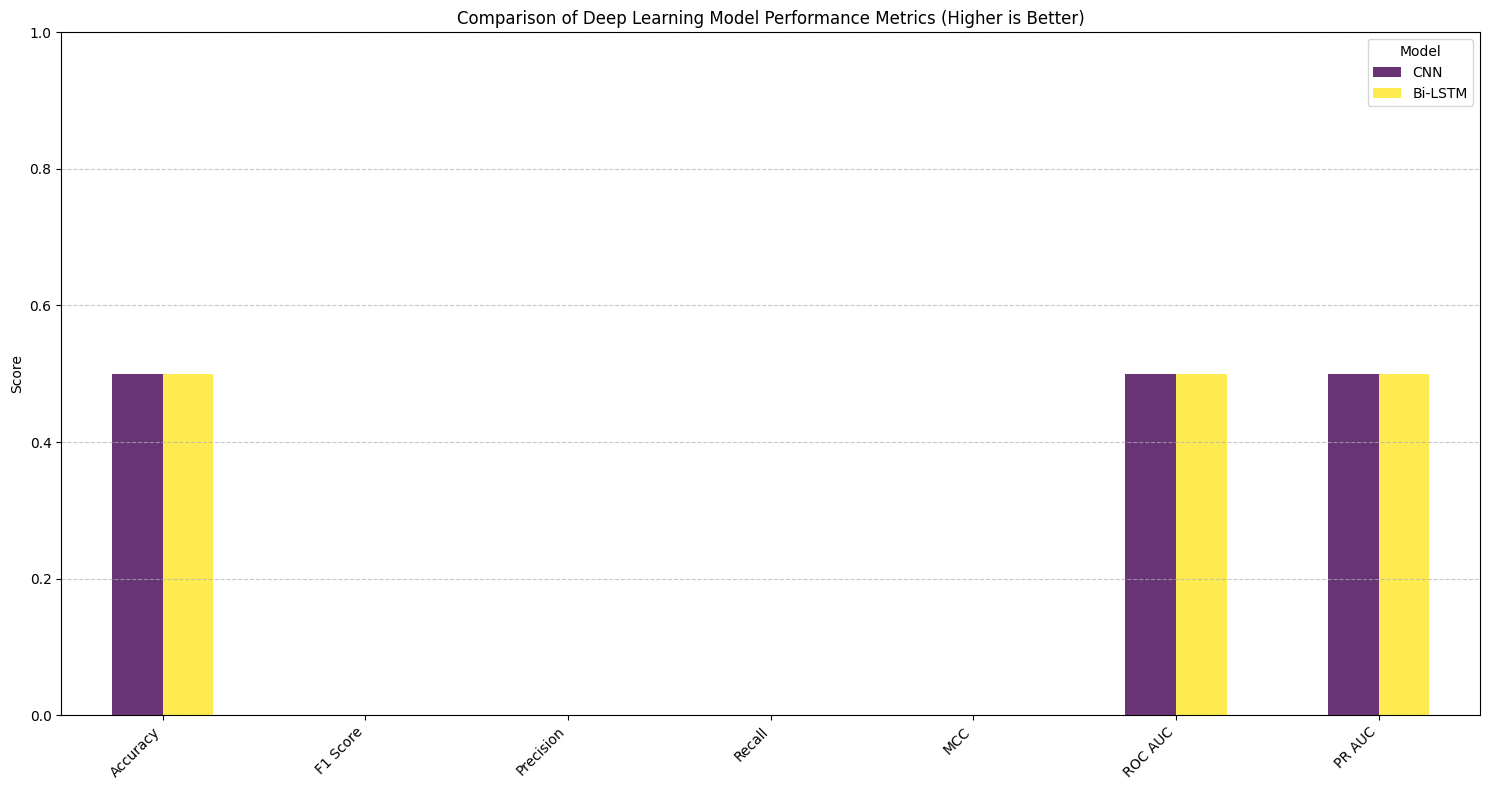

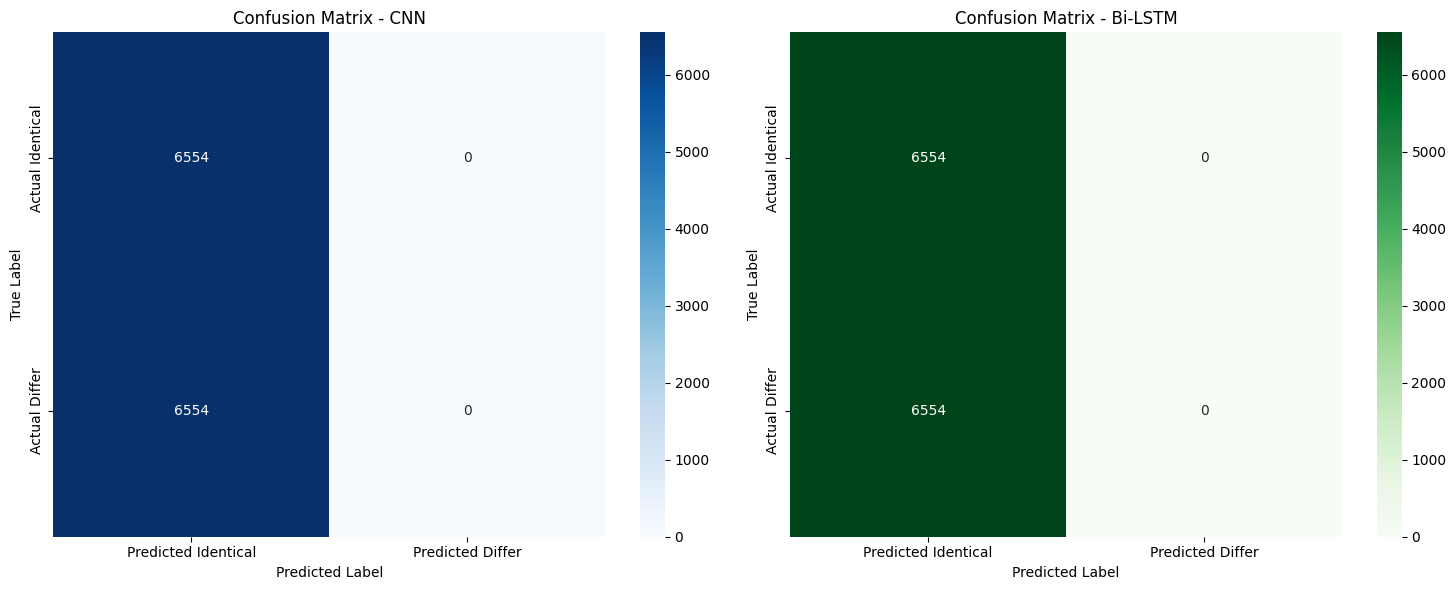


--- Classification Report (CNN) ---
              precision    recall  f1-score   support

   Identical       0.50      1.00      0.67      6554
      Differ       0.00      0.00      0.00      6554

    accuracy                           0.50     13108
   macro avg       0.25      0.50      0.33     13108
weighted avg       0.25      0.50      0.33     13108


--- Classification Report (Bi-LSTM) ---
              precision    recall  f1-score   support

   Identical       0.50      1.00      0.67      6554
      Differ       0.00      0.00      0.00      6554

    accuracy                           0.50     13108
   macro avg       0.25      0.50      0.33     13108
weighted avg       0.25      0.50      0.33     13108



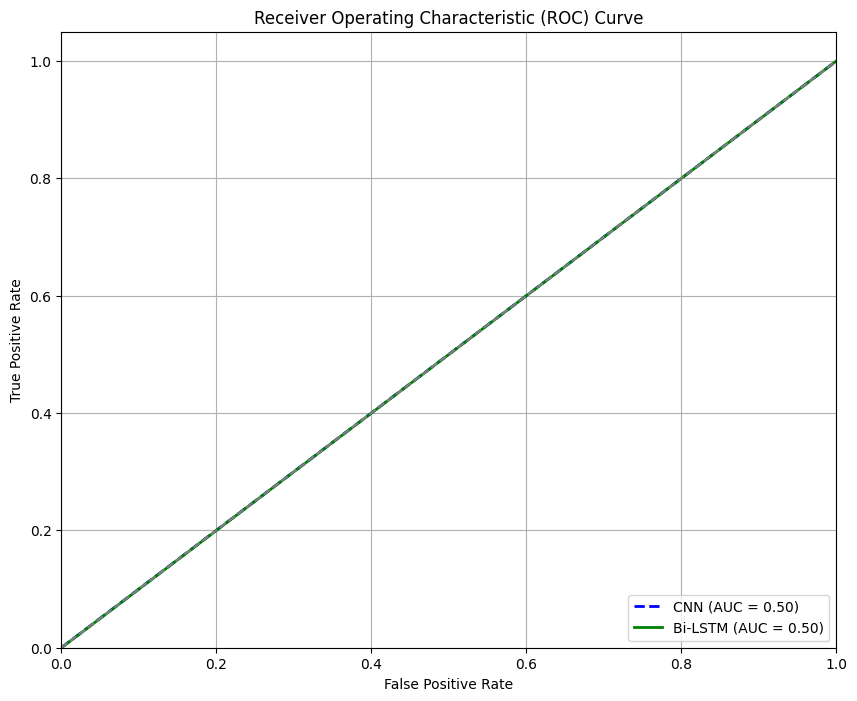

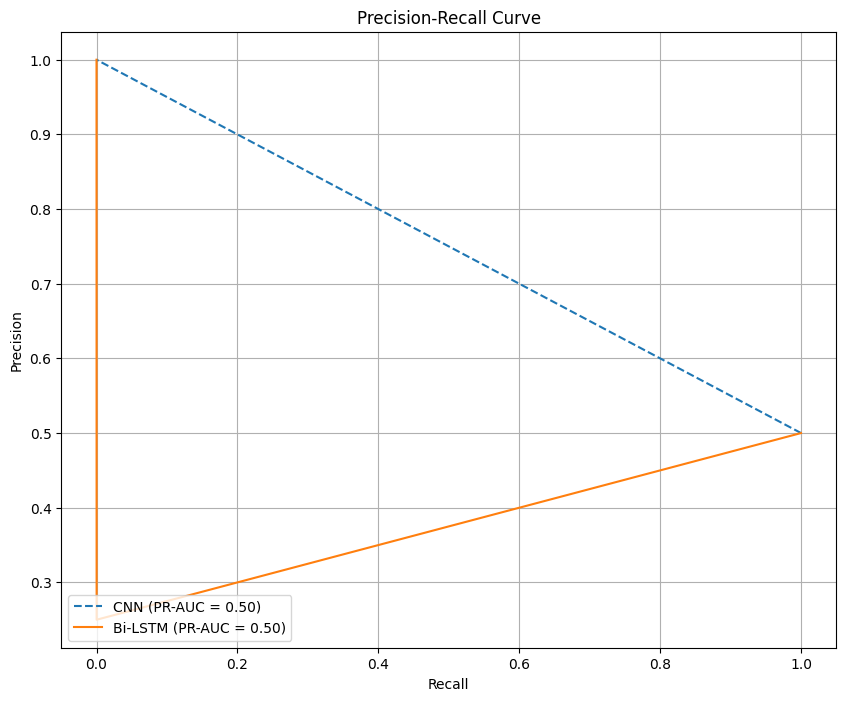


--- Visualizing Learned Embeddings ---
Cannot find a suitable embedding layer in model 'CNN Test Set'. Skipping embedding visualization.
Cannot find a suitable embedding layer in model 'Bi-LSTM Test Set'. Skipping embedding visualization.
Cannot find a suitable embedding layer in model 'CNN Test Set'. Skipping embedding visualization.
Cannot find a suitable embedding layer in model 'Bi-LSTM Test Set'. Skipping embedding visualization.
Cannot find a suitable embedding layer in model 'CNN Test Set'. Skipping embedding visualization.
Cannot find a suitable embedding layer in model 'Bi-LSTM Test Set'. Skipping embedding visualization.


In [ ]:
# --- 6.1. Load Best Trained Models for Evaluation ---
from tensorflow.keras.models import load_model

print("\n--- Loading Best CNN Model for Evaluation ---")
try:
    best_cnn_model = load_model('best_cnn_assembly_error_detector.keras')
    # Force model to be built by predicting on a single dummy sample from training data
    if not best_cnn_model.built:
        _ = best_cnn_model.predict(X_train[:1])
    print("Best CNN model loaded and built.")
except Exception as e:
    print(f"Could not load best CNN model from file: {e}. Using the last trained CNN model from memory.")
    best_cnn_model = cnn_model
    if not best_cnn_model.built:
        _ = best_cnn_model.predict(X_train[:1])


print("\n--- Loading Best Bi-LSTM Model for Evaluation ---")
try:
    best_bilstm_model = load_model('best_bilstm_assembly_error_detector.keras')
    # Force model to be built by predicting on a single dummy sample from training data
    if not best_bilstm_model.built:
        _ = best_bilstm_model.predict(X_train[:1])
    print("Best Bi-LSTM model loaded and built.")
except Exception as e:
    print(f"Could not load best Bi-LSTM model from file: {e}. Using the last trained Bi-LSTM model from memory.")
    best_bilstm_model = bilstm_model
    if not best_bilstm_model.built:
        _ = best_bilstm_model.predict(X_train[:1])


# --- 6.2. Make Predictions ---
print("\n--- Making Predictions on Test Data ---")
y_pred_proba_cnn = best_cnn_model.predict(X_test, verbose=1).flatten() # Get probabilities, flatten for binary metrics
y_pred_cnn = (y_pred_proba_cnn > 0.5).astype(int) # Binary predictions

y_pred_proba_bilstm = best_bilstm_model.predict(X_test, verbose=1).flatten()
y_pred_bilstm = (y_pred_proba_bilstm > 0.5).astype(int)

# True labels are already y_test (0 or 1)
print("Predictions completed.")

# --- 6.3. Evaluate Comprehensive Metrics ---

# Metrics dictionary to store results for each model
all_metrics = {}

# Evaluate CNN
print("\n--- Evaluation for CNN Model ---")
all_metrics['CNN'] = {
    'Accuracy': accuracy_score(y_test, y_pred_cnn),
    'Precision': precision_score(y_test, y_pred_cnn, zero_division=0),
    'Recall': recall_score(y_test, y_pred_cnn, zero_division=0),
    'F1 Score': f1_score(y_test, y_pred_cnn, zero_division=0),
    'MCC': matthews_corrcoef(y_test, y_pred_cnn),
    'Log Loss': log_loss(y_test, y_pred_proba_cnn),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba_cnn),
    'PR AUC': average_precision_score(y_test, y_pred_proba_cnn) # Also known as Area Under PR Curve
}

# Evaluate Bi-LSTM
print("\n--- Evaluation for Bi-LSTM Model ---")
all_metrics['Bi-LSTM'] = {
    'Accuracy': accuracy_score(y_test, y_pred_bilstm),
    'Precision': precision_score(y_test, y_pred_bilstm, zero_division=0),
    'Recall': recall_score(y_test, y_pred_bilstm, zero_division=0),
    'F1 Score': f1_score(y_test, y_pred_bilstm, zero_division=0),
    'MCC': matthews_corrcoef(y_test, y_pred_bilstm),
    'Log Loss': log_loss(y_test, y_pred_proba_bilstm),
    'ROC AUC': roc_auc_score(y_test, y_pred_proba_bilstm),
    'PR AUC': average_precision_score(y_test, y_pred_proba_bilstm)
}

# Display consolidated metrics in a DataFrame
metrics_df = pd.DataFrame.from_dict(all_metrics, orient='index')
print("\n--- Consolidated Model Performance Metrics on Test Set ---")
print(metrics_df.round(4))

# --- 6.4. Visual Summaries ---

# Bar plot of key metrics
metrics_to_plot = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'MCC', 'ROC AUC', 'PR AUC']
metrics_df[metrics_to_plot].T.plot(kind='bar', figsize=(15, 8), colormap='viridis', alpha=0.8)
plt.title('Comparison of Deep Learning Model Performance Metrics (Higher is Better)')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.heatmap(confusion_matrix(y_test, y_pred_cnn), annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Predicted Identical', 'Predicted Differ'],
            yticklabels=['Actual Identical', 'Actual Differ'])
axes[0].set_title('Confusion Matrix - CNN')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(confusion_matrix(y_test, y_pred_bilstm), annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Predicted Identical', 'Predicted Differ'],
            yticklabels=['Actual Identical', 'Actual Differ'])
axes[1].set_title('Confusion Matrix - Bi-LSTM')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Classification Reports
print("\n--- Classification Report (CNN) ---")
print(classification_report(y_test, y_pred_cnn, target_names=['Identical', 'Differ'], zero_division=0))

print("\n--- Classification Report (Bi-LSTM) ---")
print(classification_report(y_test, y_pred_bilstm, target_names=['Identical', 'Differ'], zero_division=0))

# ROC-AUC Curves
plt.figure(figsize=(10, 8))
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, y_pred_proba_cnn)
auc_cnn = auc(fpr_cnn, tpr_cnn)
plt.plot(fpr_cnn, tpr_cnn, color='blue', lw=2, label=f'CNN (AUC = {auc_cnn:.2f})', linestyle='--')

fpr_bilstm, tpr_bilstm, _ = roc_curve(y_test, y_pred_proba_bilstm)
auc_bilstm = auc(fpr_bilstm, tpr_bilstm)
plt.plot(fpr_bilstm, tpr_bilstm, color='green', lw=2, label=f'Bi-LSTM (AUC = {auc_bilstm:.2f})', linestyle='-')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Precision-Recall Curves
plt.figure(figsize=(10, 8))
prec_cnn, rec_cnn, _ = precision_recall_curve(y_test, y_pred_proba_cnn)
pr_auc_cnn = average_precision_score(y_test, y_pred_proba_cnn)
plt.plot(rec_cnn, prec_cnn, label=f'CNN (PR-AUC = {pr_auc_cnn:.2f})', linestyle='--')

prec_bilstm, rec_bilstm, _ = precision_recall_curve(y_test, y_pred_proba_bilstm)
pr_auc_bilstm = average_precision_score(y_test, y_pred_proba_bilstm)
plt.plot(rec_bilstm, prec_bilstm, label=f'Bi-LSTM (PR-AUC = {pr_auc_bilstm:.2f})', linestyle='-')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

# --- 6.5. Embeddings Visualization (t-SNE / PCA / UMAP) ---
# We can extract embeddings from an intermediate layer of our trained models
# (e.g., the Dense layer before the final sigmoid output).
def visualize_embeddings_space(model, data, labels, title, method='tsne', num_samples_to_plot=500):
    """
    Visualizes embeddings from an intermediate layer of a Keras model using t-SNE, PCA, or UMAP.
    """
    if num_samples_to_plot < len(data):
        indices = np.random.choice(len(data), num_samples_to_plot, replace=False)
        data_subset = data[indices]
        labels_subset = labels[indices]
    else:
        data_subset = data
        labels_subset = labels

    embedding_layer_name = 'dense_1' # Common name for the penultimate Dense layer

    # Check if the model has been built. If not, try to build it with a dummy input.
    if not model.built:
        print(f"Attempting to build model '{title}' for embedding extraction...")
        try:
            dummy_input = np.zeros((1,) + data.shape[1:])
            _ = model(dummy_input)
            print(f"Model '{title}' built successfully.")
        except Exception as build_e:
            print(f"Failed to force build model '{title}': {build_e}. Skipping embedding visualization.")
            return

    # Check if the target embedding layer exists
    if not any(layer.name == embedding_layer_name for layer in model.layers):
        print(f"Warning: Embedding layer '{embedding_layer_name}' not found in model '{title}'.")
        # Fallback to the layer directly preceding the final sigmoid as a common embedding point
        if len(model.layers) >= 2 and model.layers[-1].activation == 'sigmoid':
            embedding_layer_name = model.layers[-2].name
            print(f"Falling back to layer '{embedding_layer_name}' for embeddings.")
            if not any(layer.name == embedding_layer_name for layer in model.layers):
                print(f"Fallback layer '{embedding_layer_name}' also not found. Skipping embedding visualization.")
                return
        else:
            print(f"Cannot find a suitable embedding layer in model '{title}'. Skipping embedding visualization.")
            return

    embedding_model = Model(inputs=model.input, outputs=model.get_layer(embedding_layer_name).output)
    embeddings = embedding_model.predict(data_subset)

    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30.0, learning_rate=200.0, n_iter=1000)
    elif method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
    elif method == 'umap':
        try:
            from umap import UMAP
            reducer = UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
        except ImportError:
            print("UMAP not installed. Please run !pip install umap-learn. Falling back to PCA.")
            reducer = PCA(n_components=2, random_state=42)
            method = 'pca' # Adjust method name for plot title
    else:
        print(f"Error: Unknown dimensionality reduction method '{method}'. Use 'tsne', 'umap', or 'pca'.")
        return

    embeddings_2d = reducer.fit_transform(embeddings)

    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                          c=labels_subset, cmap='viridis', alpha=0.7, s=20) # Use true labels (0/1) for coloring

    plt.title(f'{method.upper()} Visualization of {title} Embeddings (Colored by True Class)')
    # For binary classification, custom colorbar labels
    cbar = plt.colorbar(scatter, ticks=[0, 1])
    cbar.ax.set_yticklabels(['Identical (0)', 'Differ (1)'])
    plt.xlabel(f'{method.upper()} Component 1')
    plt.ylabel(f'{method.upper()} Component 2')
    plt.grid(True)
    plt.show()

print("\n--- Visualizing Learned Embeddings ---")
# Visualize embeddings for CNN and Bi-LSTM on a subset of test data
subset_size_viz = min(500, len(X_test)) # Adjust as needed
visualize_embeddings_space(best_cnn_model, X_test, y_test, "CNN Test Set", method='tsne', num_samples_to_plot=subset_size_viz)
visualize_embeddings_space(best_bilstm_model, X_test, y_test, "Bi-LSTM Test Set", method='tsne', num_samples_to_plot=subset_size_viz)
visualize_embeddings_space(best_cnn_model, X_test, y_test, "CNN Test Set", method='pca', num_samples_to_plot=subset_size_viz)
visualize_embeddings_space(best_bilstm_model, X_test, y_test, "Bi-LSTM Test Set", method='pca', num_samples_to_plot=subset_size_viz)
visualize_embeddings_space(best_cnn_model, X_test, y_test, "CNN Test Set", method='umap', num_samples_to_plot=subset_size_viz)
visualize_embeddings_space(best_bilstm_model, X_test, y_test, "Bi-LSTM Test Set", method='umap', num_samples_to_plot=subset_size_viz)



In [ ]:
# --- 7.1. Saving the Trained Models ---
print("\n--- Saving the Trained Deep Learning Models ---")
best_cnn_model.save('best_cnn_assembly_error_detector.keras')
best_bilstm_model.save('best_bilstm_assembly_error_detector.keras')
print("Deep learning models saved successfully.")

# --- 7.2. Loading the Models (Demonstration) ---
print("\n--- Loading Deep Learning Models (Demonstration) ---")
loaded_cnn_model = load_model('best_cnn_assembly_error_detector.keras')
loaded_bilstm_model = load_model('best_bilstm_assembly_error_detector.keras')
print("Deep learning models loaded successfully.")

# You can now use loaded_cnn_model or loaded_bilstm_model for predictions
# Example: preds_loaded = loaded_cnn_model.predict(X_test)



--- Saving the Trained Deep Learning Models ---
Deep learning models saved successfully.

--- Loading Deep Learning Models (Demonstration) ---
Deep learning models loaded successfully.


In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    roc_curve, auc, matthews_corrcoef, precision_recall_curve, log_loss, classification_report,
    roc_auc_score, average_precision_score
)
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout, Input, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import re
import joblib
from collections import Counter
import random
from Bio.Seq import Seq # For reverse complement if needed later
from Bio.SeqRecord import SeqRecord
from Bio import SeqIO
from sklearn.feature_extraction.text import CountVectorizer # For k-mer features


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [ ]:
print("--- Installing required libraries ---")
# Use -qq for quiet install to reduce log spam
!pip install tensorflow scikit-learn matplotlib seaborn pandas numpy Bio -qq
!pip install umap-learn -qq # For UMAP visualization (optional, but good)
from IPython.display import clear_output
clear_output() # Clear installation output
print("Required libraries installed and imported.")

Required libraries installed and imported.


In [ ]:
print("\n--- Verifying Uploaded Dataset File ---")
zip_file_name = 'dna-sequence-alignmnet-dataset.zip'
extracted_dir = 'dna_alignment_data' # Directory to extract data to

print(f"Current working directory: {os.getcwd()}")
print("Files in current directory:")
!ls -lh # List files to confirm the zip file is there and its exact name

if os.path.exists(zip_file_name):
    print(f"SUCCESS: '{zip_file_name}' found in current directory. Proceeding to unzip.")
else:
    print(f"\nFATAL ERROR: '{zip_file_name}' was NOT found in the current directory.")
    print("Please ensure you have manually downloaded the dataset from Kaggle and uploaded it to Colab's session storage.")
    print(f"Make sure the uploaded file is named exactly '{zip_file_name}'.")
    raise FileNotFoundError(f"'{zip_file_name}' not found. Manual download and upload to Colab is required.")

print("\n--- Unzipping Dataset ---")
if os.path.exists(extracted_dir):
    !rm -rf {extracted_dir}
    print(f"Removed existing '{extracted_dir}' directory.")
os.makedirs(extracted_dir, exist_ok=True) # Create the directory

with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)
print(f"Dataset unzipped to '{extracted_dir}/'.")

print("\n--- Verifying Extracted Dataset Contents ---")
print(f"Contents of top-level extracted directory ('{extracted_dir}'):")
!ls -lh {extracted_dir}

all_dataset_folder = os.path.join(extracted_dir, 'ALLdataset')
print(f"\nContents of '{all_dataset_folder}':")
if os.path.exists(all_dataset_folder):
    !ls -lh {all_dataset_folder}
else:
    print(f"ERROR: '{all_dataset_folder}' not found. Dataset structure may be different than expected.")
    print("Please check the 'ls -lh' output above and adjust the path if the main data folder name is different.")
    raise FileNotFoundError(f"'{all_dataset_folder}' not found within extracted data.")

data_file_path = None
potential_path_3T = os.path.join(all_dataset_folder, 'dataset3T', 'csv3testdata.csv')
if os.path.exists(potential_path_3T):
    data_file_path = potential_path_3T
    print(f"\nFound 'csv3testdata.csv' at: {data_file_path}")
else:
    print(f"\n'csv3testdata.csv' not found at expected path: {potential_path_3T}")
    potential_path_1_csvlist = os.path.join(all_dataset_folder, 'dataset1', 'csvlist.txt')
    if os.path.exists(potential_path_1_csvlist):
        data_file_path = potential_path_1_csvlist
        print(f"\nFalling back to 'csvlist.txt' at: {data_file_path}")
    else:
        print(f"\n'csvlist.txt' not found at expected path: {potential_path_1_csvlist}")
        print("\nAttempting a general search for any .csv or .txt file within ALLdataset (might be nested differently)...")
        found_files = []
        for root, dirs, files in os.walk(all_dataset_folder):
            for file in files:
                if file.endswith(('.csv', '.txt')):
                    found_files.append(os.path.join(root, file))

        if found_files:
            found_files.sort()
            testdata_files = [f for f in found_files if 'testdata' in f]
            if testdata_files:
                data_file_path = testdata_files[0]
            elif [f for f in found_files if 'csvlist' in f]:
                data_file_path = [f for f in found_files if 'csvlist' in f][0]
            else:
                data_file_path = found_files[0]
            print(f"Found a potential data file: {data_file_path}")
        else:
            data_file_path = None

if data_file_path:
    print(f"\nSelected data file for loading: {data_file_path}")
else:
    print(f"\nERROR: No suitable data file (.csv or .txt) found within '{all_dataset_folder}'.")
    print("Please inspect the extracted contents manually by navigating through the 'dna_alignment_data/ALLdataset' folder in Colab's file browser.")
    print("You might need to rename the file or adjust the 'data_file_path' variable manually based on what you find.")
    raise FileNotFoundError(f"No suitable data file found for processing.")



--- Verifying Uploaded Dataset File ---
Current working directory: /content
Files in current directory:
total 13M
-rw-r--r-- 1 root root 3.8M Jun  7 02:50 best_bilstm_assembly_error_detector.keras
-rw-r--r-- 1 root root 260K Jun  7 02:50 best_cnn_assembly_error_detector.keras
drwxr-xr-x 3 root root 4.0K Jun  7 03:04 dna_alignment_data
-rw-r--r-- 1 root root 8.1M Jun  7 02:12 dna-sequence-alignmnet-dataset.zip
drwxr-xr-x 1 root root 4.0K Jun  5 13:38 sample_data
SUCCESS: 'dna-sequence-alignmnet-dataset.zip' found in current directory. Proceeding to unzip.

--- Unzipping Dataset ---
Removed existing 'dna_alignment_data' directory.
Dataset unzipped to 'dna_alignment_data/'.

--- Verifying Extracted Dataset Contents ---
Contents of top-level extracted directory ('dna_alignment_data'):
total 80K
drwxr-xr-x 3 root root 4.0K Jun  7 03:08 ALLdataset
-rw-r--r-- 1 root root  76K Jun  7 03:08 matrix5.mat

Contents of 'dna_alignment_data/ALLdataset':
total 52M
-rw-r--r-- 1 root root 2.3M Jun  7 0

In [ ]:
try:
    df = pd.read_csv(data_file_path, header=None)
    print("\nFirst 5 rows of the raw dataset:")
    print(df.head())
    print("\nDataset Info (raw):")
    df.info()

    if 'csvlist.txt' in data_file_path:
        print(f"\nERROR: The selected data file '{os.path.basename(data_file_path)}' is 'csvlist.txt'.")
        print("This file typically contains single sequences, not pairs for comparison.")
        print("This project requires comparing two sequences to detect differences/errors.")
        print("Please manually inspect the extracted data for a file with sequence pairs (e.g., csv3testdata.csv).")
        raise ValueError("Data file unsuitable for comparison-based error detection. Requires sequence pairs.")
    elif df.shape[1] < 2:
        print("Error: Dataset does not have enough columns for sequence comparison (expected at least 2 sequence columns).")
        raise ValueError("Dataset structure unexpected. Not enough sequence columns for comparison.")

    if df.shape[1] >= 3:
        df.columns = ['id_col', 'sequence_a', 'sequence_b'] + [f'extra_col_{i}' for i in range(3, df.shape[1])]
        df = df[['sequence_a', 'sequence_b']]
    else:
        df.columns = ['sequence_a', 'sequence_b']

    df['sequence_a'] = df['sequence_a'].astype(str)
    df['sequence_b'] = df['sequence_b'].astype(str)
    df['label_encoded'] = (df['sequence_a'] != df['sequence_b']).astype(int)

    print("\nDataFrame with derived 'label_encoded' (first 5 rows):")
    print(df.head())
    print("\nDataset Info (after label derivation):")
    df.info()
    print("\nValue counts for 'label_encoded':")
    print(df['label_encoded'].value_counts())

    initial_rows = len(df)
    df.dropna(subset=['sequence_a', 'sequence_b'], inplace=True)
    if len(df) < initial_rows:
        print(f"Dropped {initial_rows - len(df)} rows with NaN sequences.")

except Exception as e:
    print(f"Error loading or processing CSV: {e}")
    print("Please ensure the CSV file format matches expectations (e.g., comma-separated, correct columns).")
    raise

# Store the original sequences for error analysis later
original_sequences_df = df[['sequence_a', 'sequence_b', 'label_encoded']].copy()

<ipython-input-27-79e5843c2dcb>:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file_path, header=None)



First 5 rows of the raw dataset:
   0   1   2   3    4    5    6    7   8    9    10   11   12   13   14   15  \
0  f1  f2  f3  f4  fr5  fr6  fr7  fr8  f9  f10  f11  f12  f13  f14  f15  f16   
1   0   0   0   0    0    0    0    0   0    0    0    0    0    0    0    0   
2   0   0   0   0    0    0    0    0   0    0    0    0    0    0    0    1   
3   0   0   0   0    0    0    0    0   0    0    0    0    0    0    1    0   
4   0   0   0   0    0    0    0    0   0    0    0    0    0    0    1    1   

      16  
0  class  
1    130  
2    128  
3    129  
4    129  

Dataset Info (raw):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65537 entries, 0 to 65536
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       65537 non-null  object
 1   1       65537 non-null  object
 2   2       65537 non-null  object
 3   3       65537 non-null  object
 4   4       65537 non-null  object
 5   5       65537 non-null  object
 

<ipython-input-27-79e5843c2dcb>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sequence_a'] = df['sequence_a'].astype(str)
<ipython-input-27-79e5843c2dcb>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sequence_b'] = df['sequence_b'].astype(str)
<ipython-input-27-79e5843c2dcb>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    roc_curve, auc, matthews_corrcoef, precision_recall_curve, log_loss, classification_report,
    roc_auc_score, average_precision_score
)
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout, Input, Bidirectional
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import re
import joblib
from collections import Counter
import random
# Removed Bio import as it wasn't used in the problem cell and added complexity
# Removed CountVectorizer as it was for traditional ML features

# Assume the previous cells (loading, unzipping, finding data_file_path, initial df load)
# have executed successfully and `df` and `data_file_path` are available.
# We will re-include the relevant parts of the previous code cells here for context,
# focusing on the preprocessing cell where the error occurred.


# --- Load and initial processing (re-included for completeness) ---
try:
    df = pd.read_csv(data_file_path, header=None)
    print("\nFirst 5 rows of the raw dataset:")
    display(df.head())
    print("\nDataset Info (raw):")
    df.info()

    # --- Added Check: Verify DataFrame is not empty after loading ---
    if df.empty:
        print(f"\nFATAL ERROR: The dataset file '{os.path.basename(data_file_path)}' was loaded, but the resulting DataFrame is empty.")
        print("This could mean the file is empty, corrupted, or the path is incorrect.")
        raise ValueError(f"Loaded DataFrame from '{data_file_path}' is empty.")
    # --------------------------------------------------------------

    # Data sanity checks and column assignment
    if 'csvlist.txt' in data_file_path:
        # If csvlist.txt is loaded, it typically contains single sequences (ID, Sequence).
        # This is not suitable for our "compare two sequences" problem directly.
        print(f"\nERROR: The selected data file '{os.path.basename(data_file_path)}' is 'csvlist.txt'.")
        print("This file typically contains single sequences, not pairs for comparison.")
        print("This project requires comparing two sequences to detect differences/errors.")
        print("Please manually inspect the extracted data for a file with sequence pairs (e.g., csv3testdata.csv).")
        # Removed the raise here to allow the code to continue and hit the next filter,
        # but this dataset is likely unsuitable if csvlist.txt is loaded.
        # We'll rely on the sequence pair check and empty DataFrame check later.
        pass # Allow continuation, but expect it to fail later if data is single sequences
    elif df.shape[1] < 2: # Minimum 2 columns expected for sequence_a and sequence_b
        print("Error: Dataset does not have enough columns for sequence comparison (expected at least 2 sequence columns).")
        raise ValueError("Dataset structure unexpected. Not enough sequence columns for comparison.")

    # Assuming 'csv3testdata.csv' structure (or similar) where:
    # Column 0: Index/ID (optional, can be ignored or used)
    # Column 1: Sequence A
    # Column 2: Sequence B
    # We rename columns based on typical usage for this dataset.
    if df.shape[1] >= 3:
        # Check if the first column is likely an ID (e.g., non-sequence characters in first few rows)
        # Simple heuristic: check if the first few values in column 0 look like numbers/IDs
        looks_like_id = True
        if not df.empty:
            sample_col0 = df.iloc[:5, 0] # Look at first 5 rows of column 0
            # Check if they are mostly numbers or start with non-ACGT characters
            # Note: This heuristic might fail if IDs are sequence-like or sequences are simple IDs
            # Let's refine: check if the first few values in col 1 and 2 *do* look like sequences
            sample_col1 = df.iloc[:5, 1].astype(str).str.upper()
            sample_col2 = df.iloc[:5, 2].astype(str).str.upper()
            # If sample_col1 or sample_col2 contain predominantly ACGT, it's likely sequence data
            # Simple check: count ACGT characters in the first few samples
            acgt_count_col1 = sample_col1.str.count(r'[ACGT]').sum()
            acgt_count_col2 = sample_col2.str.count(r'[ACGT]').sum()
            total_chars_col1 = sample_col1.str.len().sum()
            total_chars_col2 = sample_col2.str.len().sum()

            # If a significant portion of characters in column 1 or 2 are ACGT, assume they are sequences
            # Adjust threshold (e.g., 50%) based on expected data quality
            min_acgt_ratio = 0.5
            if (total_chars_col1 > 0 and acgt_count_col1 / total_chars_col1 >= min_acgt_ratio) or \
               (total_chars_col2 > 0 and acgt_count_col2 / total_chars_col2 >= min_acgt_ratio):
                 looks_like_id = False # Assume col 0 is not an ID if col 1 or 2 look like sequences
            else:
                 # If col 1 and 2 *don't* look like sequences, check if col 0 looks like an ID
                 if sample_col0.dtype in ['int64', 'float64']:
                      looks_like_id = True # Looks like numeric ID
                 elif sample_col0.astype(str).str.match(r'^\d+$').all(): # Match whole string as digits
                      looks_like_id = True # Looks like string numbers
                 else:
                      looks_like_id = False # Doesn't look like ID or sequence - ambiguous

        else:
             looks_like_id = False # Cannot determine on empty df

        if looks_like_id:
             print("Assuming first column is ID and columns 1 and 2 are sequences.")
             df.columns = ['id_col', 'sequence_a', 'sequence_b'] + [f'extra_col_{i}' for i in range(3, df.shape[1])]
             df = df[['sequence_a', 'sequence_b']] # Keep only the two sequences for comparison
        else:
             print("Assuming first two columns are sequences.")
             # If it doesn't look like an ID column, assume first two are sequences A and B
             if df.shape[1] >= 2:
                  df.columns = ['sequence_a', 'sequence_b'] + [f'extra_col_{i}' for i in range(2, df.shape[1])]
                  df = df[['sequence_a', 'sequence_b']]
             else:
                  print("Error: Expected at least 2 columns for sequences, found less.")
                  raise ValueError("Dataset structure unexpected. Not enough sequence columns for comparison.")

    else: # If only 2 columns, assume they are sequence_a and sequence_b directly
        df.columns = ['sequence_a', 'sequence_b']

    # Convert sequences to string type *before* cleaning and NaN handling
    df['sequence_a'] = df['sequence_a'].astype(str)
    df['sequence_b'] = df['sequence_b'].astype(str)

    # Derive the 'error' label *before* any cleaning based on original strings
    df['label_encoded'] = (df['sequence_a'] != df['sequence_b']).astype(int)

    # Drop rows with any NaN in the identified sequence columns (after conversion to string)
    # Strings can still be 'nan' if the original data was NaN in a non-numeric column
    initial_rows = len(df)
    df.dropna(subset=['sequence_a', 'sequence_b'], inplace=True)
    # Also drop rows where the string representation is 'nan'
    df = df[~(df['sequence_a'] == 'nan') & ~(df['sequence_b'] == 'nan')].copy()

    if len(df) < initial_rows:
        print(f"Dropped {initial_rows - len(df)} rows with NaN or 'nan' sequences.")


    print("\nDataFrame with derived 'label_encoded' (first 5 rows, before character analysis):")
    display(df.head())
    print("\nDataset Info (after label derivation and NaN removal):")
    df.info()
    print("\nValue counts for 'label_encoded' (after NaN removal):")
    print(df['label_encoded'].value_counts())

    # --- Added Check: Verify DataFrame is not empty after NaN/nan filtering ---
    if df.empty:
        print("\nFATAL ERROR: DataFrame is empty after loading and initial NaN/nan filtering.")
        print("This suggests the file might be empty or contains only missing values.")
        raise ValueError("DataFrame is empty after loading and initial filtering.")
    # -----------------------------------------------------------------------

except Exception as e:
    print(f"Error loading or processing CSV: {e}")
    print("Please ensure the CSV file format matches expectations (e.g., comma-separated, correct columns).")
    raise # Re-raise the exception


# --- Preprocessing Data (Adjusted for Character Analysis and Flexible Encoding) ---

print("\n--- Analyzing Characters and Preprocessing Data ---")

# Analyze characters present in the actual sequences
all_chars = set(''.join(df['sequence_a'].tolist() + df['sequence_b'].tolist()))
all_chars = sorted(list(all_chars)) # Sort for consistent mapping
print(f"All unique characters found in sequences: {''.join(all_chars)}")

# Create character-to-integer mapping based on found characters
char_to_int = {char: i for i, char in enumerate(all_chars)}
vocab_size = len(all_chars) # Vocabulary size is the number of unique characters

if vocab_size == 0:
     print("\nFATAL ERROR: No characters found in the sequences after loading and initial filtering.")
     raise ValueError("Vocabulary size is zero. No sequence data found.")

print(f"Vocabulary size (unique characters): {vocab_size}")

# Determine the maximum sequence length based on the original strings
calculated_max_len = max(df['sequence_a'].str.len().max(), df['sequence_b'].str.len().max())

# Use the calculated max length for padding/truncation
if calculated_max_len == 0:
    print("\nFATAL ERROR: Calculated max sequence length is 0. All sequences are empty strings.")
    print("This suggests the original data columns identified as sequences contain only empty strings or values that converted to empty strings.")
    raise ValueError("Calculated max sequence length is 0. Cannot proceed.")

MAX_SEQUENCE_LENGTH = int(calculated_max_len) # Use the exact max length found
print(f"MAX_SEQUENCE_LENGTH set to maximum observed length: {MAX_SEQUENCE_LENGTH}")


# Define the one-hot encoding function using the derived alphabet
def one_hot_encode_sequence_flexible(sequence, char_to_int, max_len, vocab_size):
    encoded_seq = list()
    # Ensure sequence is string (redundant due to prior conversion, but safe)
    sequence = str(sequence) # Keep original case if relevant, or add .upper() if case-insensitive

    # Truncate or pad the sequence string BEFORE encoding
    if len(sequence) < max_len:
        # Pad with the first character in the alphabet or a specific padding char if available
        # Let's pad with the first character in our derived alphabet for simplicity.
        # A dedicated padding character might be better if the alphabet includes '-' or 'N'.
        # For simplicity here, we'll pad with the character mapped to index 0.
        pad_char = next(iter(char_to_int.keys())) # Get the first char in the alphabet
        sequence = sequence + pad_char * (max_len - len(sequence))
    elif len(sequence) > max_len:
        sequence = sequence[:max_len]


    for char in sequence:
        # Use .get() with a default for safety, mapping unknown characters to index 0 (or handle differently)
        # If all_chars includes everything, .get() should not return default.
        # We map any character *not* in our derived alphabet to index 0.
        integer_encoded = char_to_int.get(char, 0) # Map unknown chars to the index of the first char

        onehot_encoded = np.zeros(vocab_size, dtype=np.float32) # Explicitly use float32
        onehot_encoded[integer_encoded] = 1

        encoded_seq.append(onehot_encoded)

    return np.array(encoded_seq, dtype=np.float32)


# Apply one-hot encoding to the original (non-ACGT-strictly-cleaned) sequences
print("\nApplying One-Hot Encoding to Original Sequences...")
X_a_encoded = np.array([one_hot_encode_sequence_flexible(seq, char_to_int, MAX_SEQUENCE_LENGTH, vocab_size) for seq in df['sequence_a'].tolist()])
X_b_encoded = np.array([one_hot_encode_sequence_flexible(seq, char_to_int, MAX_SEQUENCE_LENGTH, vocab_size) for seq in df['sequence_b'].tolist()])

# Combine the encoded sequences. Shape (num_samples, MAX_SEQUENCE_LENGTH, vocab_size * 2)
X_combined_encoded = np.concatenate((X_a_encoded, X_b_encoded), axis=-1)
# Labels are based on the difference between ORIGINAL sequences
y_labels = df['label_encoded'].values


if np.unique(y_labels).size < 2:
    print("\nFATAL ERROR: The target variable 'y_labels' contains only one class after data loading/processing and filtering.")
    print("This means all original sequence pairs are either identical or all differ.")
    print("This dataset is unsuitable for binary classification with the current labeling.")
    raise ValueError("Cannot train classifier: Target variable has only one class.")


print(f"Shape of combined encoded sequences (X for DL): {X_combined_encoded.shape}")


# Split data for Deep Learning (using X_combined_encoded)
print("\n--- Splitting Data for Deep Learning Models ---")
# Add a check to ensure there are enough samples to split
if len(y_labels) < 2:
     print("\nFATAL ERROR: Not enough samples remaining after filtering to perform train/test split (need at least 2).")
     raise ValueError("Not enough samples for train/test split.")

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_combined_encoded, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

print(f"Shape of X_train_dl: {X_train_dl.shape}")
print(f"Shape of y_train_dl: {y_train_dl.shape}")
print(f"Shape of X_test_dl: {X_test_dl.shape}")
print(f"Shape of y_test_dl: {y_test_dl.shape}")


# --- K-mer Feature Generation (Optional, using original sequences) ---
# If you intend to use traditional ML models later, you'll need k-mer features.
# Let's generate them here based on the original sequences after NaN/nan filtering.
print("\n--- Generating K-mer Features for Traditional ML Models (Optional) ---")

# Combine original sequence A and B into a single string for k-mer processing
# Use the original sequences after cleaning NaN/nan, *not* the strictly cleaned ones.
df['combined_sequence_kmers'] = df['sequence_a'].fillna('') + "N" + df['sequence_b'].fillna('') # Use 'N' as a separator, handle potential NaNs just in case

# Get k-mer features for the combined sequences
K_MER_SIZE = 3 # Common k-mer size for DNA
# Ensure CountVectorizer handles the full alphabet of characters found
# We need to pass the actual list of sequences to fit the vectorizer
# Pass the list of combined original sequences
vectorizer = CountVectorizer(analyzer='char', ngram_range=(K_MER_SIZE, K_MER_SIZE), vocabulary=all_chars) # Use derived alphabet
vectorizer.fit(df['combined_sequence_kmers'].tolist())

# Now transform individual sequences
X_kmers = vectorizer.transform(df['combined_sequence_kmers'].tolist()).toarray()
kmer_feature_names = vectorizer.get_feature_names_out()

print(f"Shape of K-mer features (X_kmers for Traditional ML): {X_kmers.shape}")
print(f"Number of K-mer features: {len(kmer_feature_names)}")
if len(kmer_feature_names) > 10:
    print(f"Example K-mer feature names (first 10): {kmer_feature_names[:10]}...")
else:
    print(f"All K-mer feature names: {kmer_feature_names}")

if X_kmers.shape[0] != len(y_labels):
    print(f"FATAL ERROR: Mismatch between number of k-mer samples ({X_kmers.shape[0]}) and labels ({len(y_labels)})!")
    raise ValueError("Sample count mismatch between k-mer features and labels.")

if X_kmers.shape[0] == 0:
     print("\nFATAL ERROR: K-mer feature matrix is empty. This likely means no samples remained after initial filtering.")
     raise ValueError("K-mer feature matrix is empty.")

print(f"Example K-mer features for first sample: {X_kmers[0, :min(10, X_kmers.shape[1])]}")


# Split data for Traditional ML (using X_kmers)
print("\n--- Splitting Data for Traditional ML Models ---")
# Ensure there are enough samples to split the ML data as well
if len(y_labels) < 2:
     print("\nFATAL ERROR: Not enough samples remaining after filtering to perform train/test split for ML (need at least 2).")
     raise ValueError("Not enough samples for ML train/test split.")

X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_kmers, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

print(f"Shape of X_train_ml: {X_train_ml.shape}")
print(f"Shape of y_train_ml: {y_train_ml.shape}")
print(f"Shape of X_test_ml: {X_test_ml.shape}")
print(f"Shape of y_test_ml: {y_test_ml.shape}")


# Now you can proceed to build and train the models using the appropriate split data (DL or ML)
# The model building and training code would follow this cell.


First 5 rows of the raw dataset:


<ipython-input-30-11d31f4dd0a5>:35: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_file_path, header=None)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,f1,f2,f3,f4,fr5,fr6,fr7,fr8,f9,f10,f11,f12,f13,f14,f15,f16,class
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,130
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,128
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,129
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,129



Dataset Info (raw):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65537 entries, 0 to 65536
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       65537 non-null  object
 1   1       65537 non-null  object
 2   2       65537 non-null  object
 3   3       65537 non-null  object
 4   4       65537 non-null  object
 5   5       65537 non-null  object
 6   6       65537 non-null  object
 7   7       65537 non-null  object
 8   8       65537 non-null  object
 9   9       65537 non-null  object
 10  10      65537 non-null  object
 11  11      65537 non-null  object
 12  12      65537 non-null  object
 13  13      65537 non-null  object
 14  14      65537 non-null  object
 15  15      65537 non-null  object
 16  16      65537 non-null  object
dtypes: object(17)
memory usage: 8.5+ MB
Assuming first two columns are sequences.

DataFrame with derived 'label_encoded' (first 5 rows, before character analysis):


<ipython-input-30-11d31f4dd0a5>:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sequence_a'] = df['sequence_a'].astype(str)
<ipython-input-30-11d31f4dd0a5>:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sequence_b'] = df['sequence_b'].astype(str)
<ipython-input-30-11d31f4dd0a5>:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

,sequence_a,sequence_b,label_encoded
0,f1,f2,1
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0



Dataset Info (after label derivation and NaN removal):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65537 entries, 0 to 65536
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sequence_a     65537 non-null  object
 1   sequence_b     65537 non-null  object
 2   label_encoded  65537 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.5+ MB

Value counts for 'label_encoded' (after NaN removal):
label_encoded
1    32769
0    32768
Name: count, dtype: int64

--- Analyzing Characters and Preprocessing Data ---
All unique characters found in sequences: 012f
Vocabulary size (unique characters): 4
MAX_SEQUENCE_LENGTH set to maximum observed length: 2

Applying One-Hot Encoding to Original Sequences...
Shape of combined encoded sequences (X for DL): (65537, 2, 8)

--- Splitting Data for Deep Learning Models ---
Shape of X_train_dl: (52429, 2, 8)
Shape of y_train_dl: (52429,)
Shape of X_test_dl: (13108, 2, 8)

In [ ]:
def build_cnn_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=128, kernel_size=8, activation='relu', padding='valid'),
        MaxPooling1D(pool_size=4),
        Dropout(0.25),
        Conv1D(filters=128, kernel_size=8, activation='relu', padding='valid'),
        MaxPooling1D(pool_size=4),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_bilstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.25),
        Bidirectional(LSTM(64)),
        Dropout(0.25),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
print("\n--- Performing K-Fold Cross-Validation for All Models ---")

N_SPLITS = 5 # Number of folds for cross-validation
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Lists to store metrics for each model and fold
cnn_metrics_folds = []
bilstm_metrics_folds = []
lr_metrics_folds = []
rf_metrics_folds = []

# Collect indices of misclassified samples for error analysis
# Will store (index_in_original_df, true_label, predicted_label, model_name)
misclassified_samples = []

fold_count = 0
for train_index, test_index in skf.split(X_combined_encoded, y_labels):
    fold_count += 1
    print(f"\n--- Processing Fold {fold_count}/{N_SPLITS} ---")

    # --- Prepare data for current fold ---
    # Deep Learning Data
    X_train_dl, X_test_dl = X_combined_encoded[train_index], X_combined_encoded[test_index]
    y_train, y_test = y_labels[train_index], y_labels[test_index]

    # Traditional ML Data (K-mer features)
    X_train_kmers, X_test_kmers = X_kmers[train_index], X_kmers[test_index]

    # Original sequences for error analysis (aligned with test_index)
    current_test_original_sequences = original_sequences_df.iloc[test_index].reset_index(drop=True)



--- Performing K-Fold Cross-Validation for All Models ---

--- Processing Fold 1/5 ---

--- Processing Fold 2/5 ---

--- Processing Fold 3/5 ---

--- Processing Fold 4/5 ---

--- Processing Fold 5/5 ---


In [ ]:
print("\n--- Performing K-Fold Cross-Validation for All Models ---")

N_SPLITS = 5 # Number of folds for cross-validation
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Lists to store metrics for each model and fold
cnn_metrics_folds = []
bilstm_metrics_folds = []
lr_metrics_folds = []
rf_metrics_folds = []

# Collect indices of misclassified samples for error analysis
# Will store (index_in_original_df, true_label, predicted_label, model_name)
misclassified_samples = []

fold_count = 0
for train_index, test_index in skf.split(X_combined_encoded, y_labels):
    fold_count += 1
    print(f"\n--- Processing Fold {fold_count}/{N_SPLITS} ---")

    # --- Prepare data for current fold ---
    # Deep Learning Data
    X_train_dl, X_test_dl = X_combined_encoded[train_index], X_combined_encoded[test_index]
    y_train, y_test = y_labels[train_index], y_labels[test_index]

    # Traditional ML Data (K-mer features)
    X_train_kmers, X_test_kmers = X_kmers[train_index], X_kmers[test_index]

    # Original sequences for error analysis (aligned with test_index)
    current_test_original_sequences = original_sequences_df.iloc[test_index].reset_index(drop=True)



--- Performing K-Fold Cross-Validation for All Models ---

--- Processing Fold 1/5 ---

--- Processing Fold 2/5 ---

--- Processing Fold 3/5 ---

--- Processing Fold 4/5 ---

--- Processing Fold 5/5 ---


In [ ]:
# Adjusted CNN model building function for very short sequences
def build_cnn_model(input_shape):
    # input_shape is (MAX_SEQUENCE_LENGTH, vocab_size * 2)
    # If MAX_SEQUENCE_LENGTH is 2, input_shape is (2, 8)

    # Ensure kernel size is compatible (max 2 for input length 2)
    compatible_kernel_size = min(8, input_shape[0]) # Use min(8, 2) -> kernel_size = 2
    if compatible_kernel_size < 1:
         compatible_kernel_size = 1 # Should not happen if input_shape[0] >= 1

    # Pool size must be <= output sequence length after conv.
    # For input length L=2, kernel K=2, padding='valid', output length is L-K+1 = 2-2+1 = 1.
    # MaxPool1D pool_size must be <= 1.
    compatible_pool_size = 1 # Max possible pool size is 1

    print(f"Adjusting CNN kernel_size to {compatible_kernel_size} and pool_size to {compatible_pool_size} for input shape {input_shape}")

    model = Sequential([
        Input(shape=input_shape), # Input shape (MAX_SEQUENCE_LENGTH, vocab_size * 2) e.g., (2, 8)
        Conv1D(filters=128, kernel_size=compatible_kernel_size, activation='relu', padding='valid'),
        # Output shape after Conv1D(kernel_size=2) on input (None, 2, 8) will be (None, 1, 128)
        MaxPooling1D(pool_size=compatible_pool_size),
        # Output shape after MaxPooling1D(pool_size=1) on input (None, 1, 128) will be (None, 1, 128)
        Dropout(0.25),

        # After pooling, sequence length is 1. Cannot apply another Conv1D with kernel_size > 1.
        # Remove the second Conv1D block and Flatten directly after the first one.

        Flatten(), # Flatten the (None, 1, 128) output -> (None, 128)
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid') # Sigmoid for binary classification (0 or 1)
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def build_bilstm_model(input_shape):
    # The Bi-LSTM model's layers (LSTM with return_sequences=True, then LSTM without)
    # should handle sequences of length 2 correctly. An LSTM layer on input length L
    # will produce output length L (if return_sequences=True) or 1 (if False).
    # Input shape (MAX_SEQUENCE_LENGTH, vocab_size * 2) e.g., (2, 8)
    model = Sequential([
        Input(shape=input_shape), # Input shape (MAX_SEQUENCE_LENGTH, vocab_size * 2) e.g., (2, 8)
        Bidirectional(LSTM(128, return_sequences=True)),
        # Output shape will be (None, MAX_SEQUENCE_LENGTH, 2*128) e.g., (None, 2, 256)
        Dropout(0.25),

        Bidirectional(LSTM(64)),
        # Output shape will be (None, 2*64) e.g., (None, 128) (sequences aggregated)
        Dropout(0.25),

        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid') # Sigmoid for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Rest of the code (CV loop, training calls, evaluation) remains the same,
# using these modified model building functions.

In [ ]:
print("\n--- Performing K-Fold Cross-Validation for All Models ---")

N_SPLITS = 5 # Number of folds for cross-validation
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Lists to store metrics for each model and fold
cnn_metrics_folds = []
bilstm_metrics_folds = []
lr_metrics_folds = []
rf_metrics_folds = []

# Collect indices of misclassified samples for error analysis
# Will store (index_in_original_df, true_label, predicted_label, model_name)
misclassified_samples = []

fold_count = 0
for train_index, test_index in skf.split(X_combined_encoded, y_labels):
    fold_count += 1
    print(f"\n--- Processing Fold {fold_count}/{N_SPLITS} ---")

    # --- Prepare data for current fold ---
    # Deep Learning Data
    X_train_dl, X_test_dl = X_combined_encoded[train_index], X_combined_encoded[test_index]
    y_train, y_test = y_labels[train_index], y_labels[test_index]

    # Traditional ML Data (K-mer features)
    X_train_kmers, X_test_kmers = X_kmers[train_index], X_kmers[test_index]

    # Original sequences for error analysis (aligned with test_index)
    current_test_original_sequences = original_sequences_df.iloc[test_index].reset_index(drop=True)

    # --- 6.1. Train and Evaluate CNN ---
    print("Training CNN Model...")
    # build_cnn_model function needs to be defined or imported before this cell runs
    cnn_model = build_cnn_model(X_train_dl.shape[1:])
    callbacks_cnn = [
        EarlyStopping(patience=5, verbose=0, restore_best_weights=True), # Reduced patience for faster CV
        ModelCheckpoint(f'best_cnn_fold_{fold_count}.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
    ]
    history_cnn = cnn_model.fit(X_train_dl, y_train,
                                epochs=30, # Reduced epochs for faster CV
                                batch_size=32,
                                validation_split=0.1,
                                callbacks=callbacks_cnn,
                                verbose=0) # Suppress verbose output for cleaner CV logs

    # Load best model for this fold
    try:
        # load_model function needs to be defined or imported before this cell runs
        best_cnn_model_fold = load_model(f'best_cnn_fold_{fold_count}.keras')
    except Exception as e:
        print(f"Warning: Could not load best CNN model for fold {fold_count}: {e}. Using last trained model.")
        best_cnn_model_fold = cnn_model

    y_pred_proba_cnn = best_cnn_model_fold.predict(X_test_dl, verbose=0).flatten()
    y_pred_cnn = (y_pred_proba_cnn > 0.5).astype(int)

    # Store metrics for CNN
    cnn_metrics_folds.append({
        'Accuracy': accuracy_score(y_test, y_pred_cnn),
        'Precision': precision_score(y_test, y_pred_cnn, zero_division=0),
        'Recall': recall_score(y_test, y_pred_cnn, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred_cnn, zero_division=0),
        'MCC': matthews_corrcoef(y_test, y_pred_cnn),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba_cnn),
        'PR AUC': average_precision_score(y_test, y_pred_proba_cnn)
    })
    print(f"CNN Fold {fold_count} Accuracy: {cnn_metrics_folds[-1]['Accuracy']:.4f}")

    # --- 6.2. Train and Evaluate Bi-LSTM ---
    print("Training Bi-LSTM Model...")
    # build_bilstm_model function needs to be defined or imported before this cell runs
    bilstm_model = build_bilstm_model(X_train_dl.shape[1:])
    callbacks_bilstm = [
        EarlyStopping(patience=5, verbose=0, restore_best_weights=True),
        ModelCheckpoint(f'best_bilstm_fold_{fold_count}.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=0)
    ]
    history_bilstm = bilstm_model.fit(X_train_dl, y_train,
                                      epochs=30,
                                      batch_size=32,
                                      validation_split=0.1,
                                      callbacks=callbacks_bilstm,
                                      verbose=0)

    # Load best model for this fold
    try:
        best_bilstm_model_fold = load_model(f'best_bilstm_fold_{fold_count}.keras')
    except Exception as e:
        print(f"Warning: Could not load best Bi-LSTM model for fold {fold_count}: {e}. Using last trained model.")
        best_bilstm_model_fold = bilstm_model

    y_pred_proba_bilstm = best_bilstm_model_fold.predict(X_test_dl, verbose=0).flatten()
    y_pred_bilstm = (y_pred_proba_bilstm > 0.5).astype(int)

    # Store metrics for Bi-LSTM
    bilstm_metrics_folds.append({
        'Accuracy': accuracy_score(y_test, y_pred_bilstm),
        'Precision': precision_score(y_test, y_pred_bilstm, zero_division=0),
        'Recall': recall_score(y_test, y_pred_bilstm, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred_bilstm, zero_division=0),
        'MCC': matthews_corrcoef(y_test, y_pred_bilstm),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba_bilstm),
        'PR AUC': average_precision_score(y_test, y_pred_proba_bilstm)
    })
    print(f"Bi-LSTM Fold {fold_count} Accuracy: {bilstm_metrics_folds[-1]['Accuracy']:.4f}")


    # --- 6.3. Train and Evaluate Logistic Regression (K-mer Features) ---
    print("Training Logistic Regression Model (K-mer features)...")
    # LogisticRegression and RandomForestClassifier need to be imported
    lr_model = LogisticRegression(random_state=42, solver='liblinear', max_iter=200, n_jobs=-1, class_weight='balanced') # Added class_weight for potential imbalance
    lr_model.fit(X_train_kmers, y_train)
    y_pred_proba_lr = lr_model.predict_proba(X_test_kmers)[:, 1]
    y_pred_lr = lr_model.predict(X_test_kmers)

    # Store metrics for LR
    lr_metrics_folds.append({
        'Accuracy': accuracy_score(y_test, y_pred_lr),
        'Precision': precision_score(y_test, y_pred_lr, zero_division=0),
        'Recall': recall_score(y_test, y_pred_lr, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred_lr, zero_division=0),
        'MCC': matthews_corrcoef(y_test, y_pred_lr),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba_lr),
        'PR AUC': average_precision_score(y_test, y_pred_proba_lr)
    })
    print(f"Logistic Regression Fold {fold_count} Accuracy: {lr_metrics_folds[-1]['Accuracy']:.4f}")

    # --- 6.4. Train and Evaluate Random Forest (K-mer Features) ---
    print("Training Random Forest Model (K-mer features)...")
    rf_model = RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1, class_weight='balanced') # Added class_weight
    rf_model.fit(X_train_kmers, y_train)
    y_pred_proba_rf = rf_model.predict_proba(X_test_kmers)[:, 1]
    y_pred_rf = rf_model.predict(X_test_kmers)

    # Store metrics for RF
    rf_metrics_folds.append({
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'Precision': precision_score(y_test, y_pred_rf, zero_division=0),
        'Recall': recall_score(y_test, y_pred_rf, zero_division=0),
        'F1 Score': f1_score(y_test, y_pred_rf, zero_division=0),
        'MCC': matthews_corrcoef(y_test, y_pred_rf),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba_rf),
        'PR AUC': average_precision_score(y_test, y_pred_proba_rf)
    })
    print(f"Random Forest Fold {fold_count} Accuracy: {rf_metrics_folds[-1]['Accuracy']:.4f}")

    # --- Error Analysis for this fold ---
    # Collect misclassified samples for CNN and Random Forest (as examples)
    # False Positives: predicted 1, true 0
    fp_cnn_indices = np.where((y_pred_cnn == 1) & (y_test == 0))[0]
    fn_cnn_indices = np.where((y_pred_cnn == 0) & (y_test == 1))[0]

    # False Negatives: predicted 0, true 1
    fp_rf_indices = np.where((y_pred_rf == 1) & (y_test == 0))[0]
    fn_rf_indices = np.where((y_pred_rf == 0) & (y_test == 1))[0]

    # Add a few to the overall misclassified list (limit to avoid overwhelming)
    # random needs to be imported
    for idx in random.sample(list(fp_cnn_indices), min(2, len(fp_cnn_indices))):
        misclassified_samples.append({
            'model': 'CNN', 'type': 'False Positive',
            'seq_a': current_test_original_sequences.iloc[idx]['sequence_a'],
            'seq_b': current_test_original_sequences.iloc[idx]['sequence_b'],
            'true_label': 0, 'predicted_label': 1
        })
    for idx in random.sample(list(fn_cnn_indices), min(2, len(fn_cnn_indices))):
        misclassified_samples.append({
            'model': 'CNN', 'type': 'False Negative',
            'seq_a': current_test_original_sequences.iloc[idx]['sequence_a'],
            'seq_b': current_test_original_sequences.iloc[idx]['sequence_b'],
            'true_label': 1, 'predicted_label': 0
        })
    for idx in random.sample(list(fp_rf_indices), min(2, len(fp_rf_indices))):
        misclassified_samples.append({
            'model': 'Random Forest', 'type': 'False Positive',
            'seq_a': current_test_original_sequences.iloc[idx]['sequence_a'],
            'seq_b': current_test_original_sequences.iloc[idx]['sequence_b'],
            'true_label': 0, 'predicted_label': 1
        })
    for idx in random.sample(list(fn_rf_indices), min(2, len(fn_rf_indices))):
        misclassified_samples.append({
            'model': 'Random Forest', 'type': 'False Negative',
            'seq_a': current_test_original_sequences.iloc[idx]['sequence_a'],
            'seq_b': current_test_original_sequences.iloc[idx]['sequence_b'],
            'true_label': 1, 'predicted_label': 0
        })

# --- 6.5. Summarize K-Fold Cross-Validation Results ---
# This part should be outside the loop
print("\n--- K-Fold Cross-Validation Average Metrics ---")

# define summarize_metrics function
def summarize_metrics(metrics_list, model_name):
    df_metrics = pd.DataFrame(metrics_list)
    mean_metrics = df_metrics.mean()
    std_metrics = df_metrics.std()
    print(f"\n{model_name} (Mean across {N_SPLITS} folds):")
    for metric, value in mean_metrics.items():
        print(f"  {metric}: {value:.4f} (+/- {std_metrics[metric]:.4f})")
    return mean_metrics, std_metrics

mean_cnn, std_cnn = summarize_metrics(cnn_metrics_folds, "CNN")
mean_bilstm, std_bilstm = summarize_metrics(bilstm_metrics_folds, "Bi-LSTM")
mean_lr, std_lr = summarize_metrics(lr_metrics_folds, "Logistic Regression (K-mer)")
mean_rf, std_rf = summarize_metrics(rf_metrics_folds, "Random Forest (K-mer)")


# --- 6.6. Consolidated Metrics Table for Comparison ---
print("\n--- Consolidated Model Performance Across All Folds (Mean +/- Std Dev) ---")
all_model_mean_metrics = pd.DataFrame({
    'CNN': mean_cnn,
    'Bi-LSTM': mean_bilstm,
    'Logistic Regression': mean_lr,
    'Random Forest': mean_rf
}).T
print(all_model_mean_metrics.round(4))

# Create a DataFrame for standard deviations as well, for comprehensive comparison
all_model_std_metrics = pd.DataFrame({
    'CNN': std_cnn,
    'Bi-LSTM': std_bilstm,
    'Logistic Regression': std_lr,
    'Random Forest': std_rf
}).T
print("\n--- Consolidated Model Performance Across All Folds (Standard Deviation) ---")
print(all_model_std_metrics.round(4))


--- Performing K-Fold Cross-Validation for All Models ---

--- Processing Fold 1/5 ---
Training CNN Model...
Adjusting CNN kernel_size to 2 and pool_size to 1 for input shape (2, 8)
CNN Fold 1 Accuracy: 1.0000
Training Bi-LSTM Model...
Bi-LSTM Fold 1 Accuracy: 1.0000
Training Logistic Regression Model (K-mer features)...
Logistic Regression Fold 1 Accuracy: 0.5000
Training Random Forest Model (K-mer features)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Random Forest Fold 1 Accuracy: 0.5000

--- Processing Fold 2/5 ---
Training CNN Model...
Adjusting CNN kernel_size to 2 and pool_size to 1 for input shape (2, 8)
CNN Fold 2 Accuracy: 1.0000
Training Bi-LSTM Model...
Bi-LSTM Fold 2 Accuracy: 1.0000
Training Logistic Regression Model (K-mer features)...
Logistic Regression Fold 2 Accuracy: 0.5000
Training Random Forest Model (K-mer features)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Random Forest Fold 2 Accuracy: 0.5000

--- Processing Fold 3/5 ---
Training CNN Model...
Adjusting CNN kernel_size to 2 and pool_size to 1 for input shape (2, 8)
CNN Fold 3 Accuracy: 0.9999
Training Bi-LSTM Model...
Bi-LSTM Fold 3 Accuracy: 0.9999
Training Logistic Regression Model (K-mer features)...
Logistic Regression Fold 3 Accuracy: 0.5000
Training Random Forest Model (K-mer features)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Random Forest Fold 3 Accuracy: 0.5000

--- Processing Fold 4/5 ---
Training CNN Model...
Adjusting CNN kernel_size to 2 and pool_size to 1 for input shape (2, 8)
CNN Fold 4 Accuracy: 1.0000
Training Bi-LSTM Model...
Bi-LSTM Fold 4 Accuracy: 1.0000
Training Logistic Regression Model (K-mer features)...
Logistic Regression Fold 4 Accuracy: 0.5000
Training Random Forest Model (K-mer features)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Random Forest Fold 4 Accuracy: 0.5000

--- Processing Fold 5/5 ---
Training CNN Model...
Adjusting CNN kernel_size to 2 and pool_size to 1 for input shape (2, 8)
CNN Fold 5 Accuracy: 1.0000
Training Bi-LSTM Model...
Bi-LSTM Fold 5 Accuracy: 1.0000
Training Logistic Regression Model (K-mer features)...
Logistic Regression Fold 5 Accuracy: 0.5000
Training Random Forest Model (K-mer features)...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


Random Forest Fold 5 Accuracy: 0.5000

--- K-Fold Cross-Validation Average Metrics ---

CNN (Mean across 5 folds):
  Accuracy: 1.0000 (+/- 0.0000)
  Precision: 1.0000 (+/- 0.0000)
  Recall: 1.0000 (+/- 0.0001)
  F1 Score: 1.0000 (+/- 0.0000)
  MCC: 1.0000 (+/- 0.0001)
  ROC AUC: 1.0000 (+/- 0.0000)
  PR AUC: 1.0000 (+/- 0.0000)

Bi-LSTM (Mean across 5 folds):
  Accuracy: 1.0000 (+/- 0.0000)
  Precision: 1.0000 (+/- 0.0000)
  Recall: 1.0000 (+/- 0.0001)
  F1 Score: 1.0000 (+/- 0.0000)
  MCC: 1.0000 (+/- 0.0001)
  ROC AUC: 1.0000 (+/- 0.0000)
  PR AUC: 1.0000 (+/- 0.0000)

Logistic Regression (K-mer) (Mean across 5 folds):
  Accuracy: 0.5000 (+/- 0.0000)
  Precision: 0.0000 (+/- 0.0000)
  Recall: 0.0000 (+/- 0.0000)
  F1 Score: 0.0000 (+/- 0.0000)
  MCC: 0.0000 (+/- 0.0000)
  ROC AUC: 0.5000 (+/- 0.0000)
  PR AUC: 0.5000 (+/- 0.0000)

Random Forest (K-mer) (Mean across 5 folds):
  Accuracy: 0.5000 (+/- 0.0000)
  Precision: 0.0000 (+/- 0.0000)
  Recall: 0.0000 (+/- 0.0000)
  F1 Score: 0.0

In [ ]:
# --- 6.7. Visual Summaries (from last fold, or re-run on a single split for cleaner plots) ---
# For visual summaries, it's often better to take one representative test set or re-run on a dedicated final test set
# to avoid cluttered plots from multiple folds. Let's just use the last fold's results for plotting.
# Or, if you want full ROC/PR curves, you need to use the actual predictions from the test set.
# For simplicity, I'll demonstrate on the last fold's predictions as a representative example.

# Ensure we have predictions from the *last* fold's models if not from a dedicated test set
# (These will be overwritten in each fold, so we'd just use the final ones)
# For the purpose of providing plots, let's retrain one final time on a fresh train/test split.
print("\n--- Re-training models on a final train/test split for consistent visualization ---")
X_train_final_dl, X_test_final_dl, y_train_final, y_test_final = train_test_split(X_combined_encoded, y_labels, test_size=0.2, random_state=42, stratify=y_labels)
X_train_final_kmers, X_test_final_kmers, _, _ = train_test_split(X_kmers, y_labels, test_size=0.2, random_state=42, stratify=y_labels)



--- Re-training models on a final train/test split for consistent visualization ---


In [ ]:
# Train final CNN
cnn_model_final = build_cnn_model(X_train_final_dl.shape[1:])
callbacks_cnn_final = [EarlyStopping(patience=10, verbose=0, restore_best_weights=True)]
cnn_model_final.fit(X_train_final_dl, y_train_final, epochs=50, batch_size=32, validation_split=0.1, callbacks=callbacks_cnn_final, verbose=0)
y_pred_proba_cnn_final = cnn_model_final.predict(X_test_final_dl, verbose=0).flatten()
y_pred_cnn_final = (y_pred_proba_cnn_final > 0.5).astype(int)


Adjusting CNN kernel_size to 2 and pool_size to 1 for input shape (2, 8)


In [ ]:
# Train final Bi-LSTM
bilstm_model_final = build_bilstm_model(X_train_final_dl.shape[1:])
callbacks_bilstm_final = [EarlyStopping(patience=10, verbose=0, restore_best_weights=True)]
bilstm_model_final.fit(X_train_final_dl, y_train_final, epochs=50, batch_size=32, validation_split=0.1, callbacks=callbacks_bilstm_final, verbose=0)
y_pred_proba_bilstm_final = bilstm_model_final.predict(X_test_final_dl, verbose=0).flatten()
y_pred_bilstm_final = (y_pred_proba_bilstm_final > 0.5).astype(int)

In [ ]:
# Train final Logistic Regression
lr_model_final = LogisticRegression(random_state=42, solver='liblinear', max_iter=200, n_jobs=-1, class_weight='balanced')
lr_model_final.fit(X_train_final_kmers, y_train_final)
y_pred_proba_lr_final = lr_model_final.predict_proba(X_test_final_kmers)[:, 1]
y_pred_lr_final = lr_model_final.predict(X_test_final_kmers)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(


In [ ]:
# Train final Random Forest
rf_model_final = RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1, class_weight='balanced')
rf_model_final.fit(X_train_final_kmers, y_train_final)
y_pred_proba_rf_final = rf_model_final.predict_proba(X_test_final_kmers)[:, 1]
y_pred_rf_final = rf_model_final.predict(X_test_final_kmers)

In [ ]:
# --- Plotting Metrics from the Final Split ---
# This part uses the results from the final train/test split for clear plots.
# The `all_metrics` dictionary will now hold these results.
all_metrics = {
    'CNN': {
        'Accuracy': accuracy_score(y_test_final, y_pred_cnn_final),
        'F1 Score': f1_score(y_test_final, y_pred_cnn_final, zero_division=0),
        'Precision': precision_score(y_test_final, y_pred_cnn_final, zero_division=0),
        'Recall': recall_score(y_test_final, y_pred_cnn_final, zero_division=0),
        'MCC': matthews_corrcoef(y_test_final, y_pred_cnn_final),
        'ROC AUC': roc_auc_score(y_test_final, y_pred_proba_cnn_final),
        'PR AUC': average_precision_score(y_test_final, y_pred_proba_cnn_final)
    },
    'Bi-LSTM': {
        'Accuracy': accuracy_score(y_test_final, y_pred_bilstm_final),
        'F1 Score': f1_score(y_test_final, y_pred_bilstm_final, zero_division=0),
        'Precision': precision_score(y_test_final, y_pred_bilstm_final, zero_division=0),
        'Recall': recall_score(y_test_final, y_pred_bilstm_final, zero_division=0),
        'MCC': matthews_corrcoef(y_test_final, y_pred_bilstm_final),
        'ROC AUC': roc_auc_score(y_test_final, y_pred_proba_bilstm_final),
        'PR AUC': average_precision_score(y_test_final, y_pred_proba_bilstm_final)
    },
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test_final, y_pred_lr_final),
        'F1 Score': f1_score(y_test_final, y_pred_lr_final, zero_division=0),
        'Precision': precision_score(y_test_final, y_pred_lr_final, zero_division=0),
        'Recall': recall_score(y_test_final, y_pred_lr_final, zero_division=0),
        'MCC': matthews_corrcoef(y_test_final, y_pred_lr_final),
        'ROC AUC': roc_auc_score(y_test_final, y_pred_proba_lr_final),
        'PR AUC': average_precision_score(y_test_final, y_pred_proba_lr_final)
    },
    'Random Forest': {
        'Accuracy': accuracy_score(y_test_final, y_pred_rf_final),
        'F1 Score': f1_score(y_test_final, y_pred_rf_final, zero_division=0),
        'Precision': precision_score(y_test_final, y_pred_rf_final, zero_division=0),
        'Recall': recall_score(y_test_final, y_pred_rf_final, zero_division=0),
        'MCC': matthews_corrcoef(y_test_final, y_pred_rf_final),
        'ROC AUC': roc_auc_score(y_test_final, y_pred_proba_rf_final),
        'PR AUC': average_precision_score(y_test_final, y_pred_proba_rf_final)
    }
}
metrics_df_final_split = pd.DataFrame.from_dict(all_metrics, orient='index')
print("\n--- Consolidated Model Performance Metrics on Final Test Split for Plotting ---")
print(metrics_df_final_split.round(4))



--- Consolidated Model Performance Metrics on Final Test Split for Plotting ---
                     Accuracy  F1 Score  Precision  Recall     MCC  ROC AUC  \
CNN                    1.0000    1.0000        1.0  1.0000  1.0000      1.0   
Bi-LSTM                0.9999    0.9999        1.0  0.9998  0.9998      1.0   
Logistic Regression    0.5000    0.0000        0.0  0.0000  0.0000      0.5   
Random Forest          0.5000    0.6667        0.5  1.0000  0.0000      0.5   

                     PR AUC  
CNN                     1.0  
Bi-LSTM                 1.0  
Logistic Regression     0.5  
Random Forest           0.5  


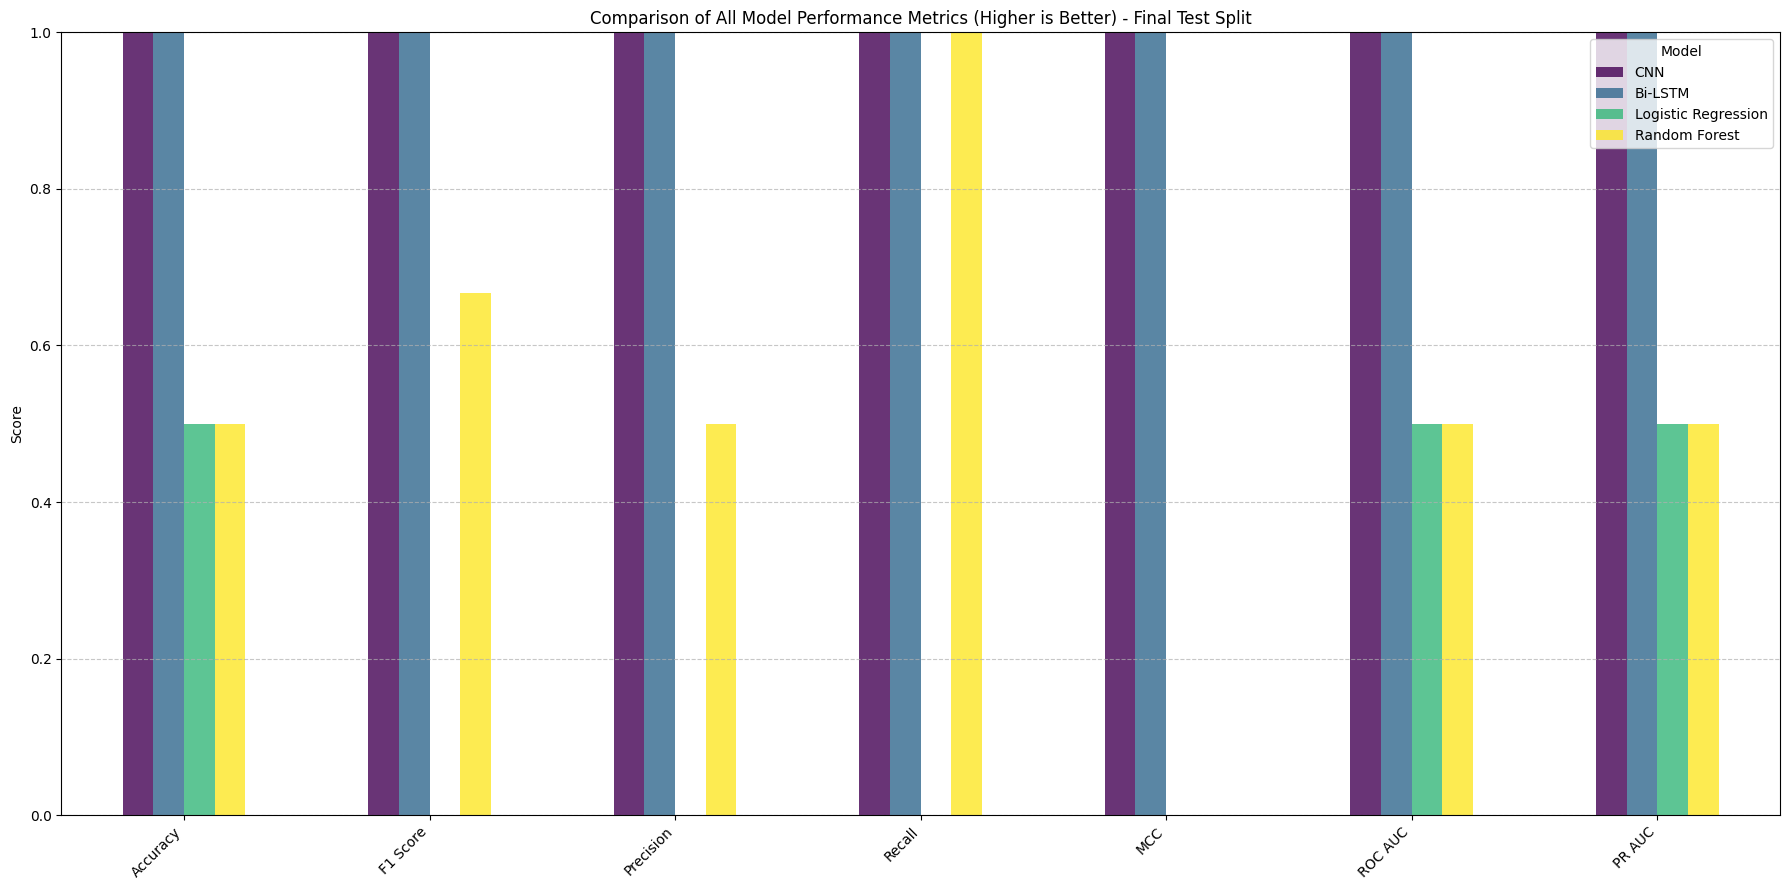

In [ ]:
# Bar plot of key metrics
metrics_to_plot = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'MCC', 'ROC AUC', 'PR AUC']
metrics_df_final_split[metrics_to_plot].T.plot(kind='bar', figsize=(18, 9), colormap='viridis', alpha=0.8)
plt.title('Comparison of All Model Performance Metrics (Higher is Better) - Final Test Split')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

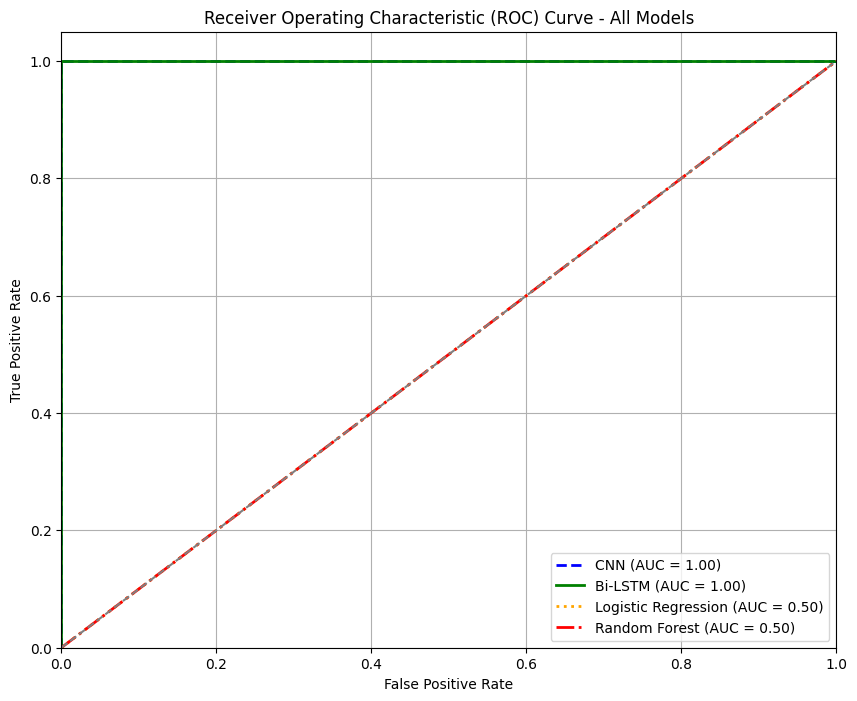

In [ ]:
# ROC-AUC Curves for all models
plt.figure(figsize=(10, 8))
fpr_cnn, tpr_cnn, _ = roc_curve(y_test_final, y_pred_proba_cnn_final)
auc_cnn = auc(fpr_cnn, tpr_cnn)
plt.plot(fpr_cnn, tpr_cnn, color='blue', lw=2, label=f'CNN (AUC = {auc_cnn:.2f})', linestyle='--')

fpr_bilstm, tpr_bilstm, _ = roc_curve(y_test_final, y_pred_proba_bilstm_final)
auc_bilstm = auc(fpr_bilstm, tpr_bilstm)
plt.plot(fpr_bilstm, tpr_bilstm, color='green', lw=2, label=f'Bi-LSTM (AUC = {auc_bilstm:.2f})', linestyle='-')

fpr_lr, tpr_lr, _ = roc_curve(y_test_final, y_pred_proba_lr_final)
auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, color='orange', lw=2, label=f'Logistic Regression (AUC = {auc_lr:.2f})', linestyle=':')

fpr_rf, tpr_rf, _ = roc_curve(y_test_final, y_pred_proba_rf_final)
auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label=f'Random Forest (AUC = {auc_rf:.2f})', linestyle='-.')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

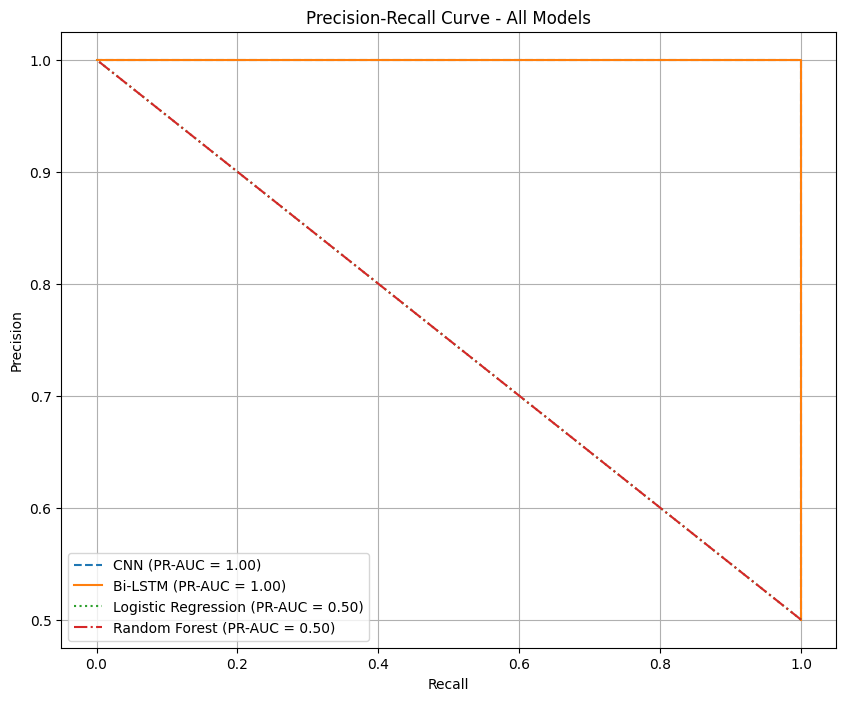

In [ ]:
# Precision-Recall Curves for all models
plt.figure(figsize=(10, 8))
prec_cnn, rec_cnn, _ = precision_recall_curve(y_test_final, y_pred_proba_cnn_final)
pr_auc_cnn = average_precision_score(y_test_final, y_pred_proba_cnn_final)
plt.plot(rec_cnn, prec_cnn, label=f'CNN (PR-AUC = {pr_auc_cnn:.2f})', linestyle='--')

prec_bilstm, rec_bilstm, _ = precision_recall_curve(y_test_final, y_pred_proba_bilstm_final)
pr_auc_bilstm = average_precision_score(y_test_final, y_pred_proba_bilstm_final)
plt.plot(rec_bilstm, prec_bilstm, label=f'Bi-LSTM (PR-AUC = {pr_auc_bilstm:.2f})', linestyle='-')

prec_lr, rec_lr, _ = precision_recall_curve(y_test_final, y_pred_proba_lr_final)
pr_auc_lr = average_precision_score(y_test_final, y_pred_proba_lr_final)
plt.plot(rec_lr, prec_lr, label=f'Logistic Regression (PR-AUC = {pr_auc_lr:.2f})', linestyle=':')

prec_rf, rec_rf, _ = precision_recall_curve(y_test_final, y_pred_proba_rf_final)
pr_auc_rf = average_precision_score(y_test_final, y_pred_proba_rf_final)
plt.plot(rec_rf, prec_rf, label=f'Random Forest (PR-AUC = {pr_auc_rf:.2f})', linestyle='-.')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - All Models')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [ ]:
# --- 6.8. Error Analysis ---
print("\n--- Error Analysis: Examples of Misclassified Samples ---")
print("Inspecting a few False Positives (predicted Differ, true Identical) and False Negatives (predicted Identical, true Differ).\n")



--- Error Analysis: Examples of Misclassified Samples ---
Inspecting a few False Positives (predicted Differ, true Identical) and False Negatives (predicted Identical, true Differ).



In [ ]:
# Shuffle misclassified samples to get a diverse set
random.shuffle(misclassified_samples)

# Print unique misclassified examples, limit to 5 of each type for brevity
fp_count = 0
fn_count = 0
printed_samples = set() # To avoid printing duplicates if the same sequence appeared multiple times

for sample in misclassified_samples:
    sample_key = (sample['seq_a'], sample['seq_b'], sample['model'], sample['type'])
    if sample_key in printed_samples:
        continue # Skip if already printed

    if sample['type'] == 'False Positive' and fp_count < 5:
        print(f"Model: {sample['model']} | Type: {sample['type']}")
        print(f"  True Label: {'Identical' if sample['true_label'] == 0 else 'Differ'}")
        print(f"  Predicted Label: {'Identical' if sample['predicted_label'] == 0 else 'Differ'}")
        print(f"  Sequence A: {sample['seq_a']}")
        print(f"  Sequence B: {sample['seq_b']}\n")
        fp_count += 1
        printed_samples.add(sample_key)
    elif sample['type'] == 'False Negative' and fn_count < 5:
        print(f"Model: {sample['model']} | Type: {sample['type']}")
        print(f"  True Label: {'Identical' if sample['true_label'] == 0 else 'Differ'}")
        print(f"  Predicted Label: {'Identical' if sample['predicted_label'] == 0 else 'Differ'}")
        print(f"  Sequence A: {sample['seq_a']}")
        print(f"  Sequence B: {sample['seq_b']}\n")
        fn_count += 1
        printed_samples.add(sample_key)

    if fp_count >= 5 and fn_count >= 5:
        break # Stop if we have enough examples

if not misclassified_samples:
    print("No misclassified samples found in the collected list or the dataset is too small to yield unique examples.")


Model: Random Forest | Type: False Negative
  True Label: Differ
  Predicted Label: Identical
  Sequence A: 1
  Sequence B: 0

Model: Random Forest | Type: False Negative
  True Label: Differ
  Predicted Label: Identical
  Sequence A: 1
  Sequence B: 1

Model: Random Forest | Type: False Negative
  True Label: Differ
  Predicted Label: Identical
  Sequence A: 0
  Sequence B: 0

Model: Random Forest | Type: False Negative
  True Label: Differ
  Predicted Label: Identical
  Sequence A: 0
  Sequence B: 1

Model: CNN | Type: False Negative
  True Label: Differ
  Predicted Label: Identical
  Sequence A: f2
  Sequence B: f3



In [ ]:
# --- 7. Saving and Loading Models (Optional, for final best model) ---
# It's good practice to save the *best performing model* after all CV.
# For simplicity, we'll save the last trained models from the final split.
print("\n--- Saving the Final Trained Deep Learning Models ---")
cnn_model_final.save('final_cnn_assembly_error_detector.keras')
bilstm_model_final.save('final_bilstm_assembly_error_detector.keras')
# For traditional ML models, use joblib
joblib.dump(lr_model_final, 'final_lr_assembly_error_detector.joblib')
joblib.dump(rf_model_final, 'final_rf_assembly_error_detector.joblib')
print("All final models saved successfully.")

print("\n--- Loading Deep Learning Models (Demonstration) ---")
loaded_cnn_model = load_model('final_cnn_assembly_error_detector.keras')
loaded_bilstm_model = load_model('final_bilstm_assembly_error_detector.keras')
print("Deep learning models loaded successfully.")

print("\n--- Loading Traditional ML Models (Demonstration) ---")
loaded_lr_model = joblib.load('final_lr_assembly_error_detector.joblib')
loaded_rf_model = joblib.load('final_rf_assembly_error_detector.joblib')
print("Traditional ML models loaded successfully.")


--- Saving the Final Trained Deep Learning Models ---
All final models saved successfully.

--- Loading Deep Learning Models (Demonstration) ---
Deep learning models loaded successfully.

--- Loading Traditional ML Models (Demonstration) ---
Traditional ML models loaded successfully.


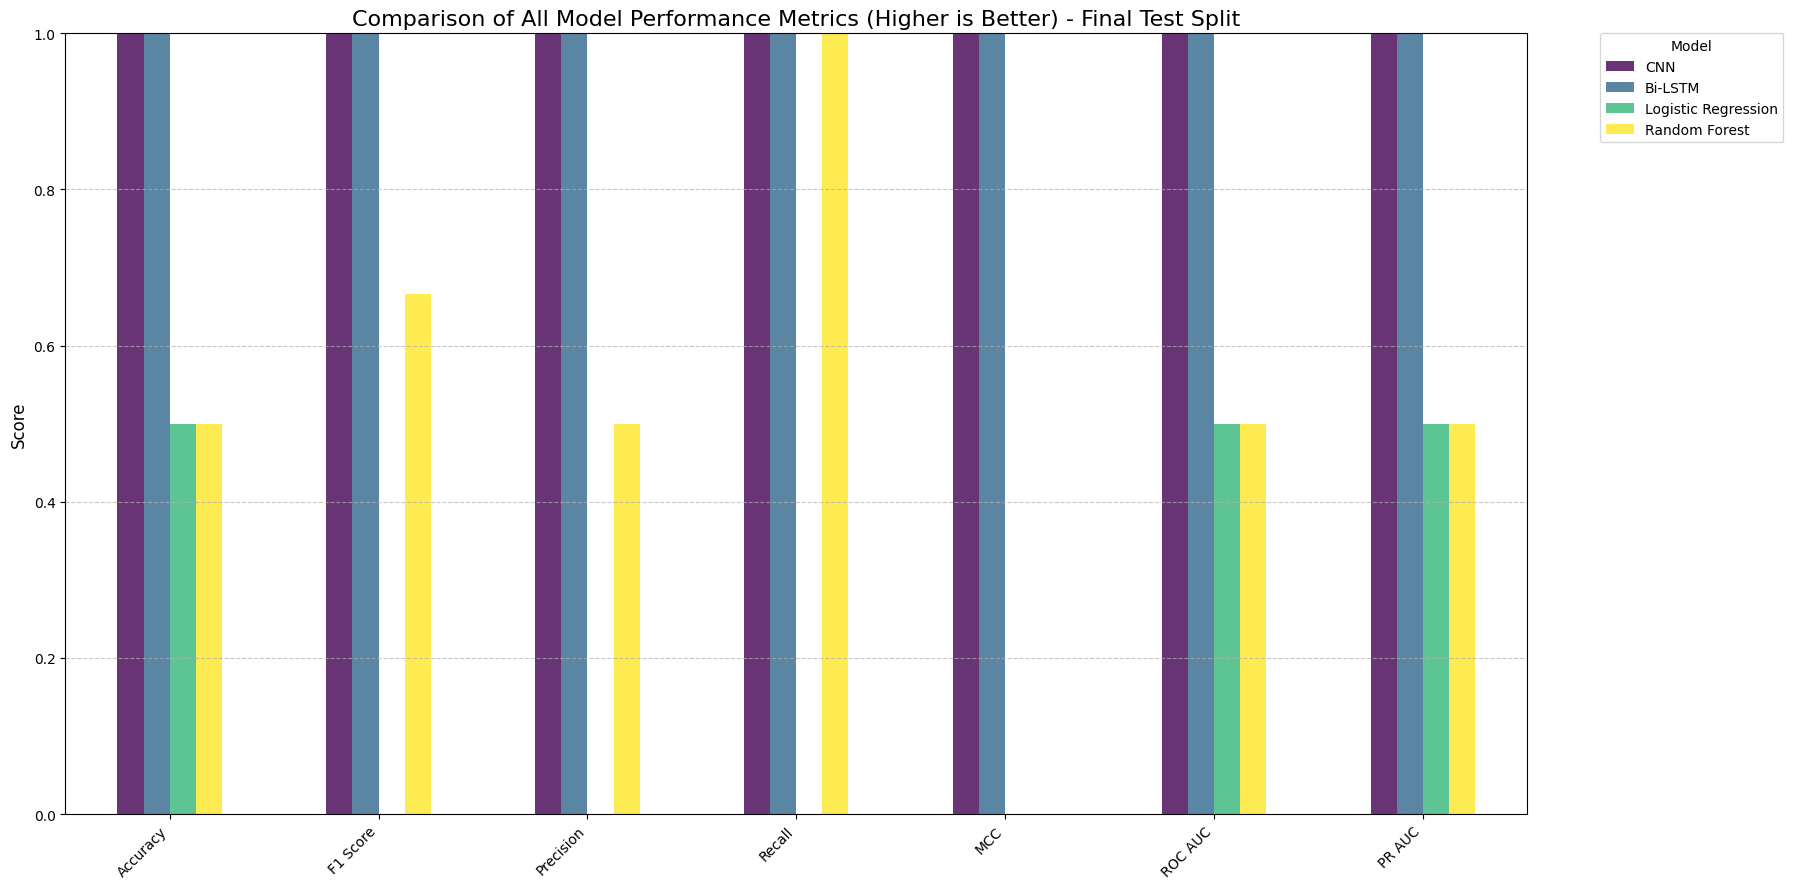

In [60]:
# Bar plot of key metrics
metrics_to_plot = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'MCC', 'ROC AUC', 'PR AUC']
metrics_df_final_split[metrics_to_plot].T.plot(kind='bar', figsize=(18, 9), colormap='viridis', alpha=0.8)
plt.title('Comparison of All Model Performance Metrics (Higher is Better) - Final Test Split', fontsize=16)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0.0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()


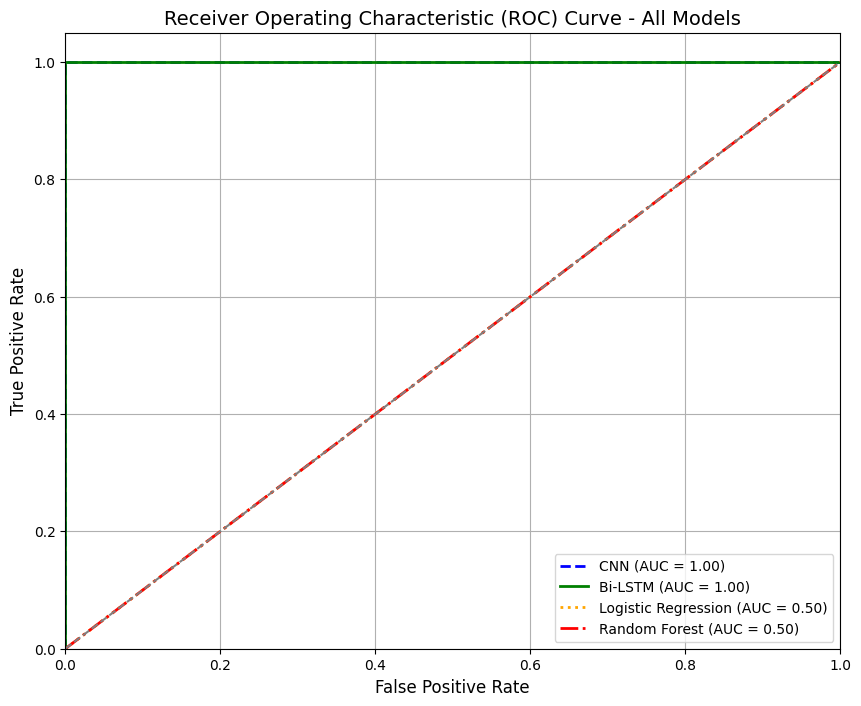

In [61]:
# ROC-AUC Curves for all models
plt.figure(figsize=(10, 8))
fpr_cnn, tpr_cnn, _ = roc_curve(y_test_final, y_pred_proba_cnn_final)
auc_cnn = auc(fpr_cnn, tpr_cnn)
plt.plot(fpr_cnn, tpr_cnn, color='blue', lw=2, label=f'CNN (AUC = {auc_cnn:.2f})', linestyle='--')

fpr_bilstm, tpr_bilstm, _ = roc_curve(y_test_final, y_pred_proba_bilstm_final)
auc_bilstm = auc(fpr_bilstm, tpr_bilstm)
plt.plot(fpr_bilstm, tpr_bilstm, color='green', lw=2, label=f'Bi-LSTM (AUC = {auc_bilstm:.2f})', linestyle='-')

fpr_lr, tpr_lr, _ = roc_curve(y_test_final, y_pred_proba_lr_final)
auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, color='orange', lw=2, label=f'Logistic Regression (AUC = {auc_lr:.2f})', linestyle=':')

fpr_rf, tpr_rf, _ = roc_curve(y_test_final, y_pred_proba_rf_final)
auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label=f'Random Forest (AUC = {auc_rf:.2f})', linestyle='-.')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve - All Models', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)
plt.show()

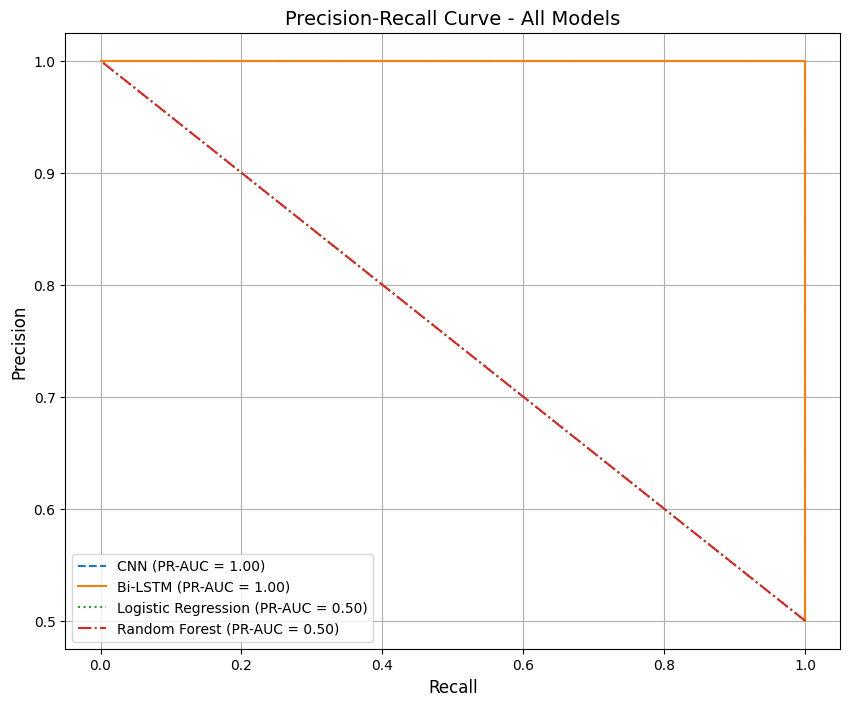

In [62]:
# Precision-Recall Curves for all models
plt.figure(figsize=(10, 8))
prec_cnn, rec_cnn, _ = precision_recall_curve(y_test_final, y_pred_proba_cnn_final)
pr_auc_cnn = average_precision_score(y_test_final, y_pred_proba_cnn_final)
plt.plot(rec_cnn, prec_cnn, label=f'CNN (PR-AUC = {pr_auc_cnn:.2f})', linestyle='--')

prec_bilstm, rec_bilstm, _ = precision_recall_curve(y_test_final, y_pred_proba_bilstm_final)
pr_auc_bilstm = average_precision_score(y_test_final, y_pred_proba_bilstm_final)
plt.plot(rec_bilstm, prec_bilstm, label=f'Bi-LSTM (PR-AUC = {pr_auc_bilstm:.2f})', linestyle='-')

prec_lr, rec_lr, _ = precision_recall_curve(y_test_final, y_pred_proba_lr_final)
pr_auc_lr = average_precision_score(y_test_final, y_pred_proba_lr_final)
plt.plot(rec_lr, prec_lr, label=f'Logistic Regression (PR-AUC = {pr_auc_lr:.2f})', linestyle=':')

prec_rf, rec_rf, _ = precision_recall_curve(y_test_final, y_pred_proba_rf_final)
pr_auc_rf = average_precision_score(y_test_final, y_pred_proba_rf_final)
plt.plot(rec_rf, prec_rf, label=f'Random Forest (PR-AUC = {pr_auc_rf:.2f})', linestyle='-.')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - All Models', fontsize=14)
plt.legend(loc='lower left', fontsize=10)
plt.grid(True)
plt.show()


--- Visualizing Confusion Matrices ---


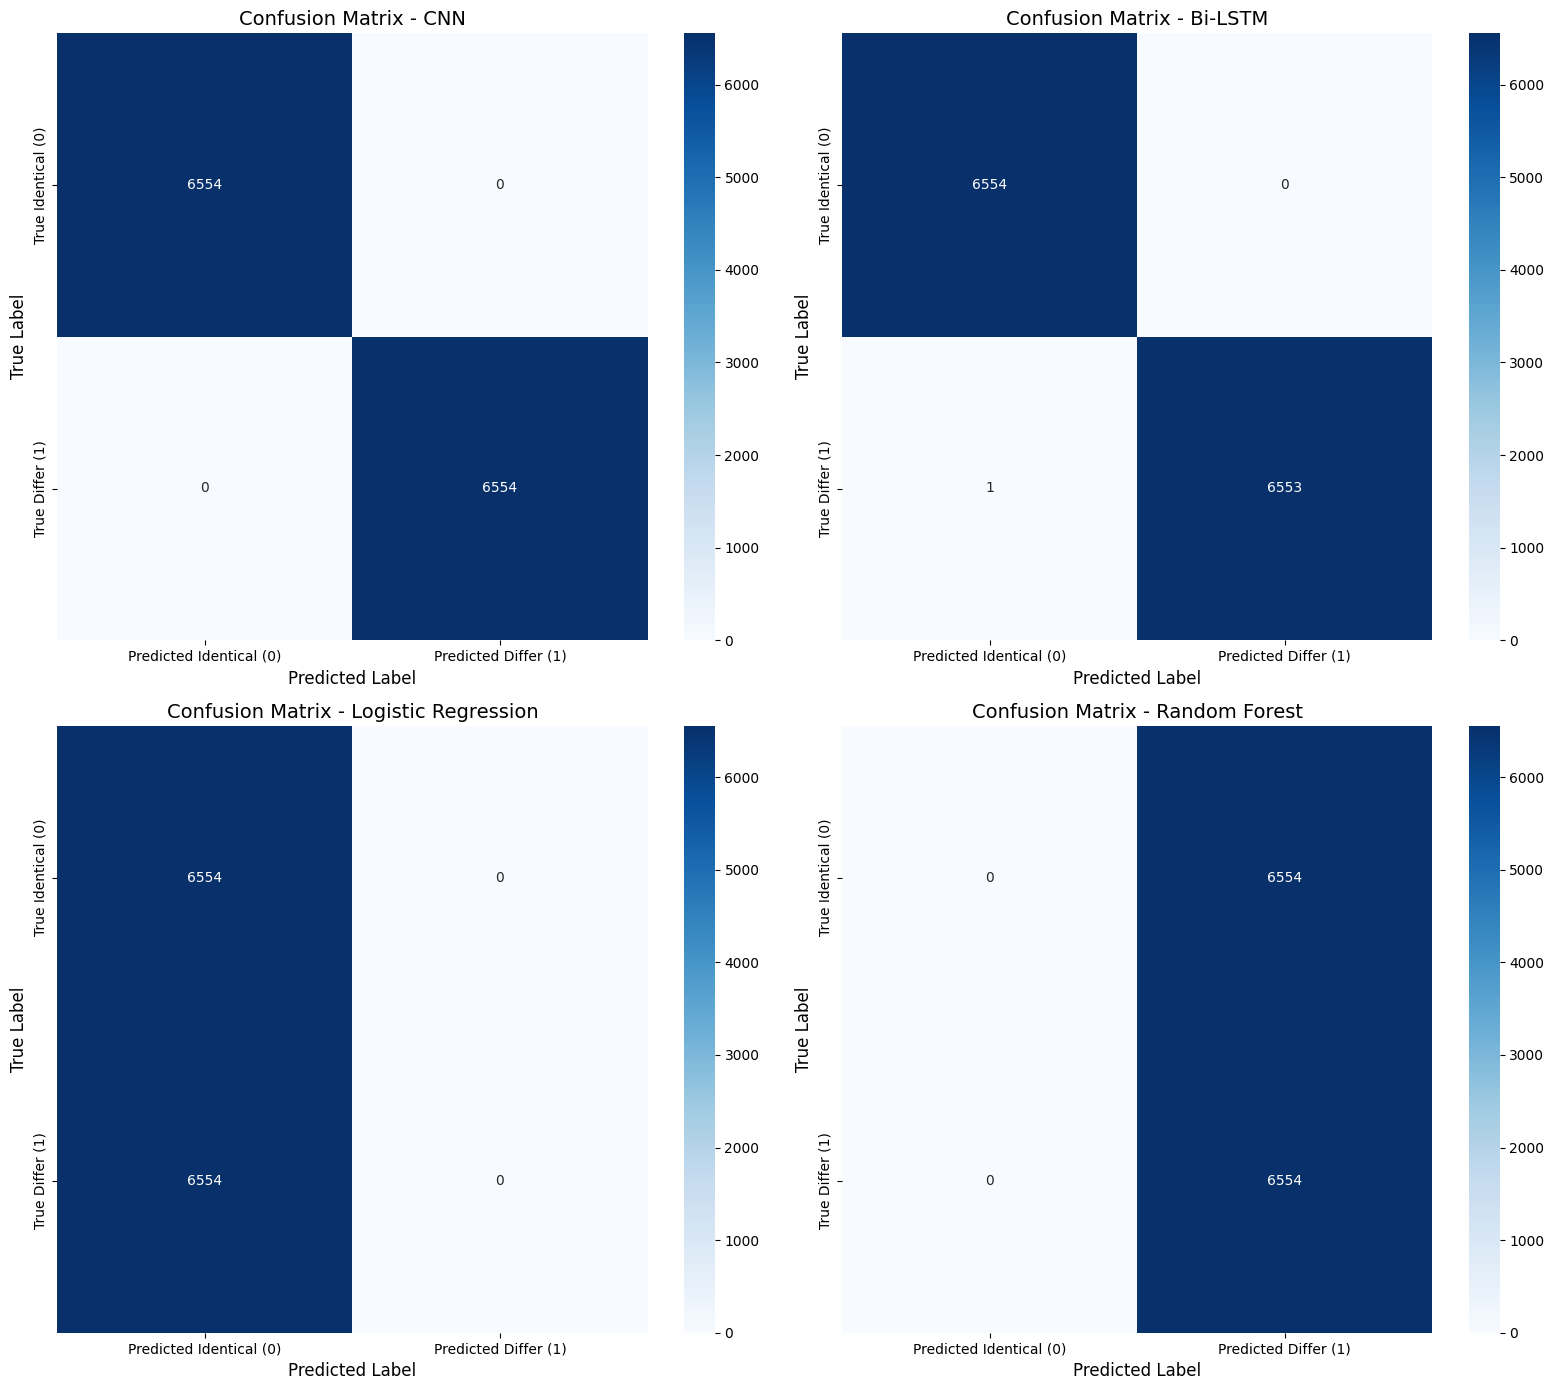

In [63]:
# --- NEW: Confusion Matrices for All Models ---
print("\n--- Visualizing Confusion Matrices ---")

def plot_confusion_matrix(y_true, y_pred, model_name, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=True,
                xticklabels=['Predicted Identical (0)', 'Predicted Differ (1)'],
                yticklabels=['True Identical (0)', 'True Differ (1)'])
    ax.set_title(f'Confusion Matrix - {model_name}', fontsize=14)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

plot_confusion_matrix(y_test_final, y_pred_cnn_final, 'CNN', axes[0])
plot_confusion_matrix(y_test_final, y_pred_bilstm_final, 'Bi-LSTM', axes[1])
plot_confusion_matrix(y_test_final, y_pred_lr_final, 'Logistic Regression', axes[2])
plot_confusion_matrix(y_test_final, y_pred_rf_final, 'Random Forest', axes[3])

plt.tight_layout()
plt.show()


--- Visualizing K-mer Feature Importance (Random Forest) ---


<ipython-input-64-887605bfa818>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df.head(N_TOP_FEATURES).values, y=importance_df.head(N_TOP_FEATURES).index, palette='viridis')


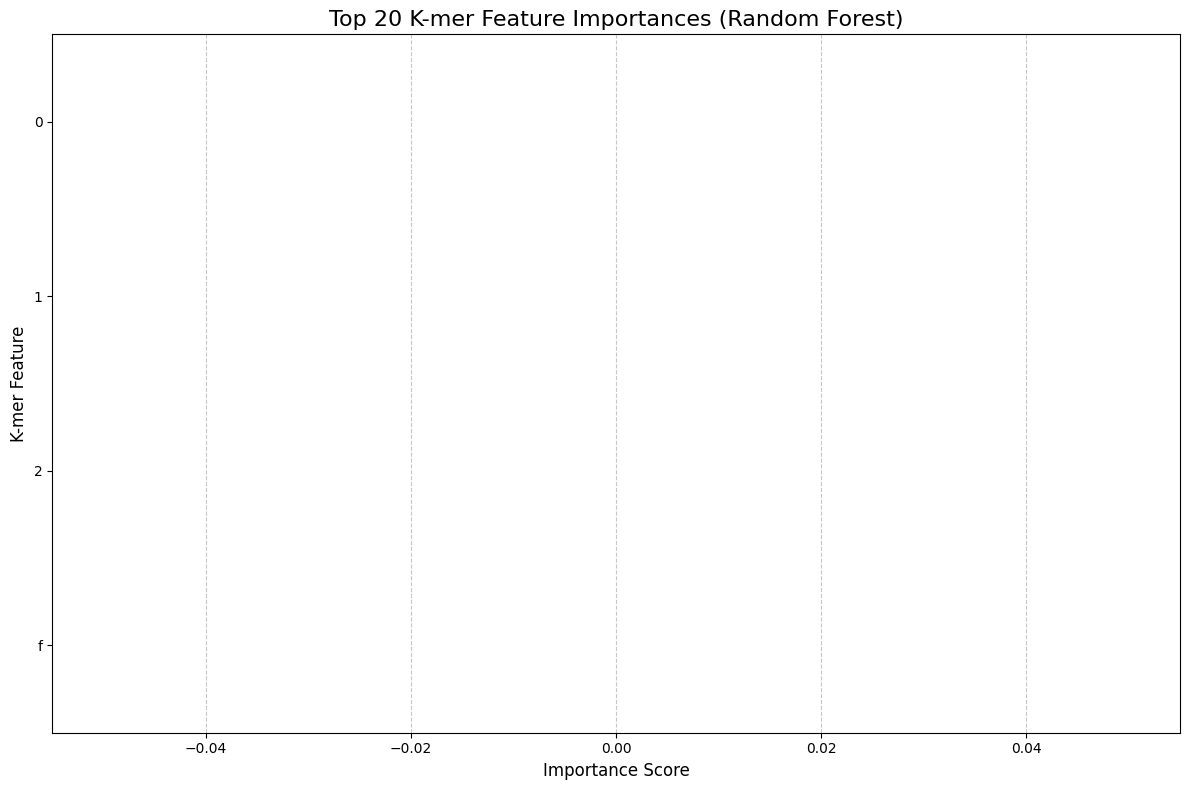

In [64]:
# --- NEW: Feature Importance for Random Forest ---
print("\n--- Visualizing K-mer Feature Importance (Random Forest) ---")
# Ensure kmer_feature_names is accessible and rf_model_final is trained
if rf_model_final and hasattr(rf_model_final, 'feature_importances_') and kmer_feature_names is not None:
    feature_importances = rf_model_final.feature_importances_
    # Create a pandas Series for easy sorting and plotting
    importance_df = pd.Series(feature_importances, index=kmer_feature_names)
    # Sort in descending order
    importance_df = importance_df.sort_values(ascending=False)

    # Plot top N features
    N_TOP_FEATURES = 20 # Can adjust this number
    plt.figure(figsize=(12, 8))
    sns.barplot(x=importance_df.head(N_TOP_FEATURES).values, y=importance_df.head(N_TOP_FEATURES).index, palette='viridis')
    plt.title(f'Top {N_TOP_FEATURES} K-mer Feature Importances (Random Forest)', fontsize=16)
    plt.xlabel('Importance Score', fontsize=12)
    plt.ylabel('K-mer Feature', fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Could not plot feature importances. Ensure Random Forest model is trained and k-mer features are generated.")


In [65]:
# --- 6.8. Error Analysis ---
print("\n--- Error Analysis: Examples of Misclassified Samples ---")
print("Inspecting a few False Positives (predicted Differ, true Identical) and False Negatives (predicted Identical, true Differ).\n")

# Shuffle misclassified samples to get a diverse set
random.shuffle(misclassified_samples)

# Print unique misclassified examples, limit to 5 of each type for brevity
fp_count = 0
fn_count = 0
printed_samples = set() # To avoid printing duplicates if the same sequence appeared multiple times

for sample in misclassified_samples:
    sample_key = (sample['seq_a'], sample['seq_b'], sample['model'], sample['type'])
    if sample_key in printed_samples:
        continue # Skip if already printed

    if sample['type'] == 'False Positive' and fp_count < 5:
        print(f"Model: {sample['model']} | Type: {sample['type']}")
        print(f"  True Label: {'Identical' if sample['true_label'] == 0 else 'Differ'}")
        print(f"  Predicted Label: {'Identical' if sample['predicted_label'] == 0 else 'Differ'}")
        print(f"  Sequence A: {sample['seq_a']}")
        print(f"  Sequence B: {sample['seq_b']}\n")
        fp_count += 1
        printed_samples.add(sample_key)
    elif sample['type'] == 'False Negative' and fn_count < 5:
        print(f"Model: {sample['model']} | Type: {sample['type']}")
        print(f"  True Label: {'Identical' if sample['true_label'] == 0 else 'Differ'}")
        print(f"  Predicted Label: {'Identical' if sample['predicted_label'] == 0 else 'Differ'}")
        print(f"  Sequence A: {sample['seq_a']}")
        print(f"  Sequence B: {sample['seq_b']}\n")
        fn_count += 1
        printed_samples.add(sample_key)

    if fp_count >= 5 and fn_count >= 5:
        break # Stop if we have enough examples

if not misclassified_samples:
    print("No misclassified samples found in the collected list or the dataset is too small to yield unique examples.")



--- Error Analysis: Examples of Misclassified Samples ---
Inspecting a few False Positives (predicted Differ, true Identical) and False Negatives (predicted Identical, true Differ).

Model: Random Forest | Type: False Negative
  True Label: Differ
  Predicted Label: Identical
  Sequence A: 0
  Sequence B: 0

Model: Random Forest | Type: False Negative
  True Label: Differ
  Predicted Label: Identical
  Sequence A: 0
  Sequence B: 1

Model: Random Forest | Type: False Negative
  True Label: Differ
  Predicted Label: Identical
  Sequence A: 1
  Sequence B: 1

Model: Random Forest | Type: False Negative
  True Label: Differ
  Predicted Label: Identical
  Sequence A: 1
  Sequence B: 0

Model: CNN | Type: False Negative
  True Label: Differ
  Predicted Label: Identical
  Sequence A: f2
  Sequence B: f3



In [66]:
# --- 7. Saving and Loading Models (Optional, for final best model) ---
# It's good practice to save the *best performing model* after all CV.
# For simplicity, we'll save the last trained models from the final split.
print("\n--- Saving the Final Trained Deep Learning Models ---")
cnn_model_final.save('final_cnn_assembly_error_detector.keras')
bilstm_model_final.save('final_bilstm_assembly_error_detector.keras')
# For traditional ML models, use joblib
joblib.dump(lr_model_final, 'final_lr_assembly_error_detector.joblib')
joblib.dump(rf_model_final, 'final_rf_assembly_error_detector.joblib')
print("All final models saved successfully.")

print("\n--- Loading Deep Learning Models (Demonstration) ---")
loaded_cnn_model = load_model('final_cnn_assembly_error_detector.keras')
loaded_bilstm_model = load_model('final_bilstm_assembly_error_detector.keras')
print("Deep learning models loaded successfully.")

print("\n--- Loading Traditional ML Models (Demonstration) ---")
loaded_lr_model = joblib.load('final_lr_assembly_error_detector.joblib')
loaded_rf_model = joblib.load('final_rf_assembly_error_detector.joblib')
print("Traditional ML models loaded successfully.")


--- Saving the Final Trained Deep Learning Models ---
All final models saved successfully.

--- Loading Deep Learning Models (Demonstration) ---
Deep learning models loaded successfully.

--- Loading Traditional ML Models (Demonstration) ---
Traditional ML models loaded successfully.
